In [43]:
import os
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile as tiff

from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker

from scipy import ndimage as ndi
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import splprep, splev
from scipy.stats import ttest_ind

from skimage.measure import regionprops, regionprops_table
from skimage.morphology import skeletonize
from skimage.draw import line

import networkx as nx

from google.colab import drive


## Load images

In [45]:


# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define the base path to the shared project directory
figure_path = os.path.join(base_path, "figures/")

# Define relative paths from the base path
pathTIF = os.path.join(base_path, 'data/microfluidic/chemostat/TIF/')
print(f"[INFO] Looking for TIF images in: {pathTIF}")

# Define the experiment ID
experiment_id = "grx_xy18"

# Define the expected channels to load
channels_to_load = ["DIC", "GFP", "RED", "MASK", "CELLS"]

# Dictionary to store images
images = {}

# Load the multi-frame TIFs
for channel in channels_to_load:
    file_name = f"{experiment_id}_{channel}.tif"
    file_path = os.path.join(pathTIF, file_name)

    if os.path.exists(file_path):
        try:
            img_data = tiff.imread(file_path)
            images[channel] = img_data.astype(np.uint16)  # Ensure 16-bit format for consistency
            print(f"[INFO] Loaded {channel} channel from {file_name}, shape: {img_data.shape}")
        except Exception as e:
            print(f"[ERROR] Failed to load {file_name}: {e}")
    else:
        print(f"[WARNING] File {file_name} not found. Skipping {channel}.")

# Display loaded channel names
print(f"\n[INFO] Successfully loaded channels: {list(images.keys())}")


# Define the frames we want to analyze
frames_to_analyze = frames_to_analyze = list(range(0, 31)) #[0, 10 ,20, 30, 40]
#frames_to_analyze = [10 ,20, 30]
output_directory = "%sdata/microfluidic/chemostat/cells/"%base_path  # Change as needed
print("output_directory=",output_directory)

pixel2um = 15  # pixels per µm
frame2min=10

ylim_length=25 #plotting limits (length)
ylim_surface_area=1e4 #plotting limits (surface_area)
ylim_volume=50 #plotting limits (volume)
ylim_sav=10e3 #plotting limits (SA/V)
frames_to_compare=[5, 17, 29]

os.makedirs(output_directory, exist_ok=True)

Mounted at /content/drive
[INFO] Looking for TIF images in: /content/drive/MyDrive/SYNC_Projects/VIP205/data/microfluidic/chemostat/TIF/
[INFO] Loaded DIC channel from grx_xy18_DIC.tif, shape: (80, 1024, 1280)
[INFO] Loaded GFP channel from grx_xy18_GFP.tif, shape: (80, 1024, 1280)
[INFO] Loaded RED channel from grx_xy18_RED.tif, shape: (80, 1024, 1280)
[INFO] Loaded MASK channel from grx_xy18_MASK.tif, shape: (80, 1024, 1280)
[INFO] Loaded CELLS channel from grx_xy18_CELLS.tif, shape: (80, 1024, 1280)

[INFO] Successfully loaded channels: ['DIC', 'GFP', 'RED', 'MASK', 'CELLS']
output_directory= /content/drive/MyDrive/SYNC_Projects/VIP205/data/microfluidic/chemostat/cells/


## Plot results

In [46]:
def generate_consistent_colors(mask_ids):
    """
    Generates consistent random colors for each mask ID.

    Parameters:
    - mask_ids (list): List of unique mask IDs.

    Returns:
    - dict: {mask_id: (R, G, B)} mapping.
    """
    random.seed(42)  # Fix seed for reproducibility
    return {mask_id: (random.random(), random.random(), random.random()) for mask_id in mask_ids}


def generate_random_colormap():
    """Generate a random 16-bit colormap for visualization."""
    from matplotlib.colors import ListedColormap

    np.random.seed(42)  # For reproducibility
    rand_colors = np.random.rand(65536, 3)  # Generate random RGB values
    rand_colors[0] = [0, 0, 0]  # Ensure background (0) remains black
    return ListedColormap(rand_colors)

# Generate a colormap for MASK and CELLS
random_cmap = generate_random_colormap()

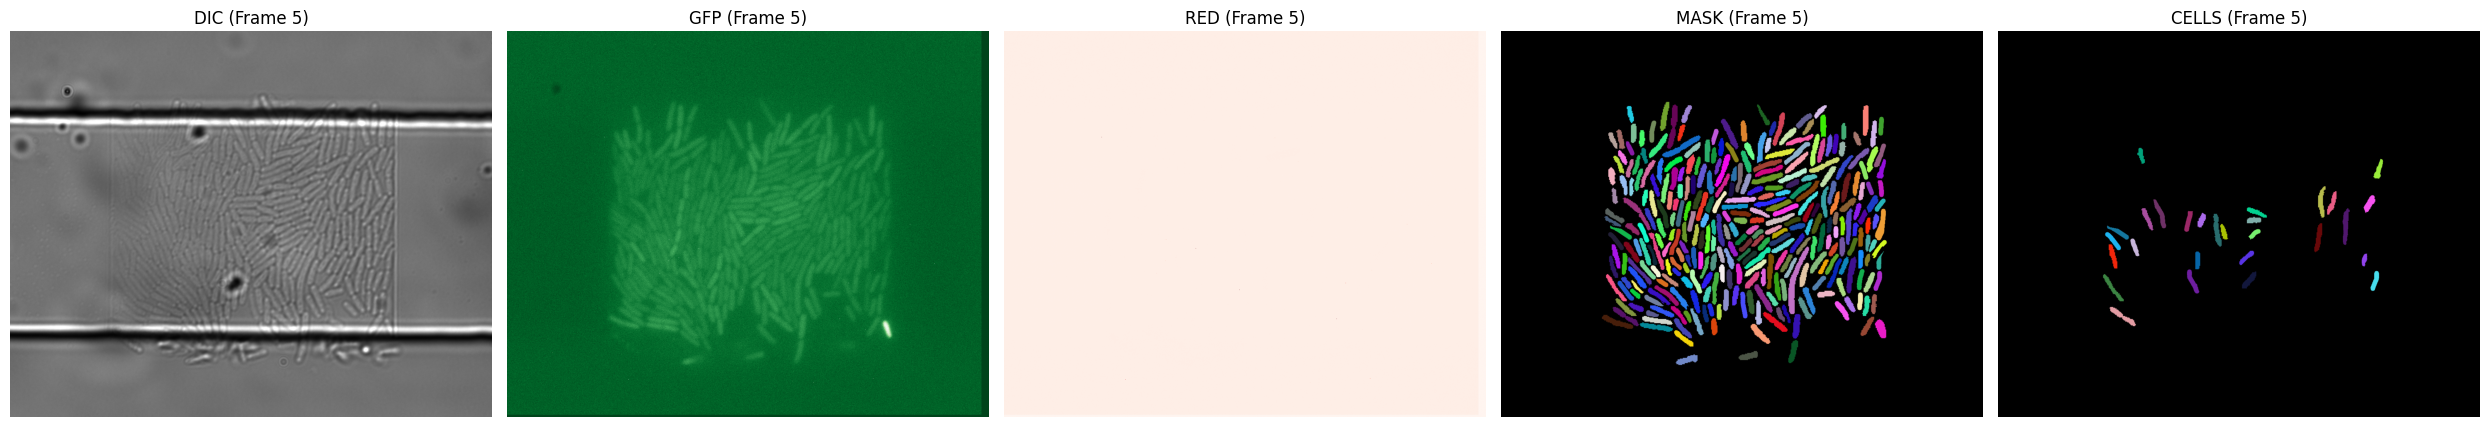

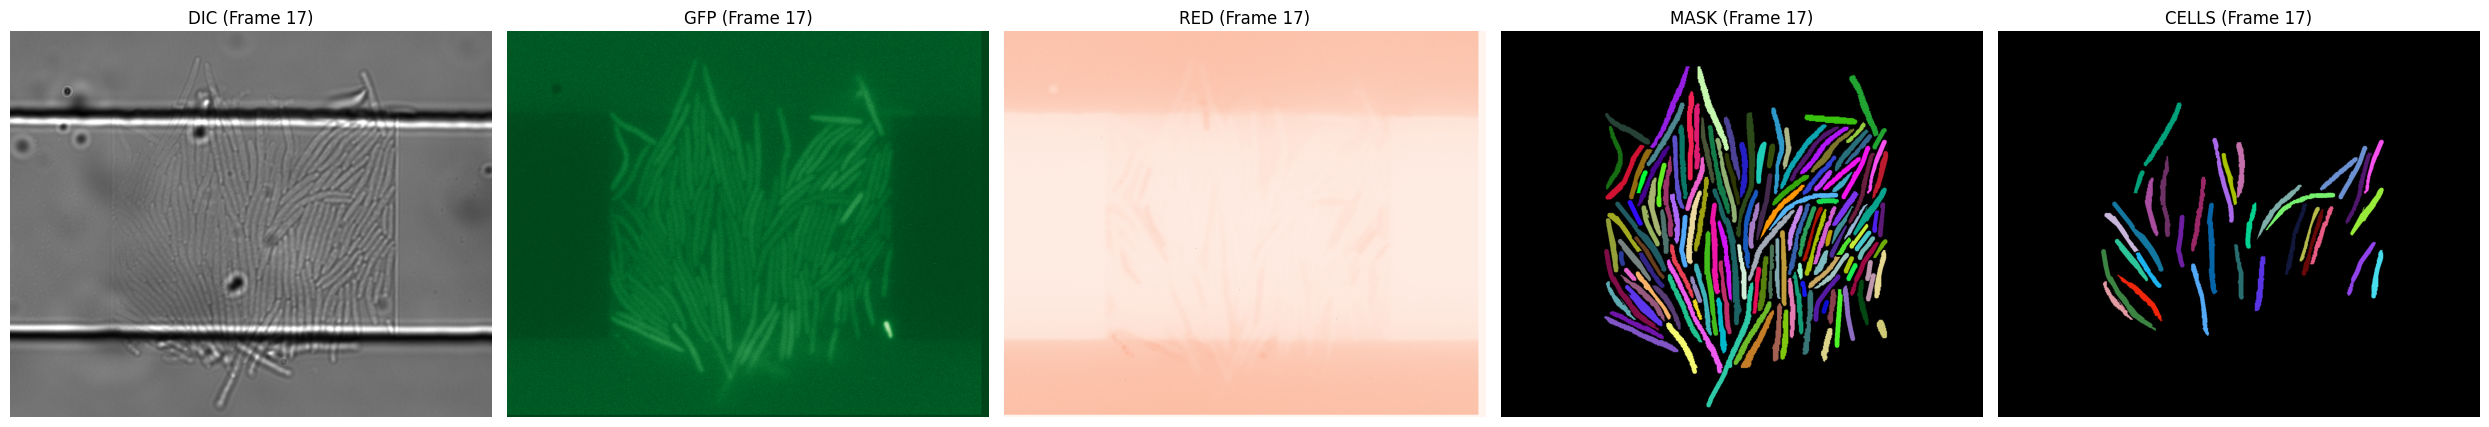

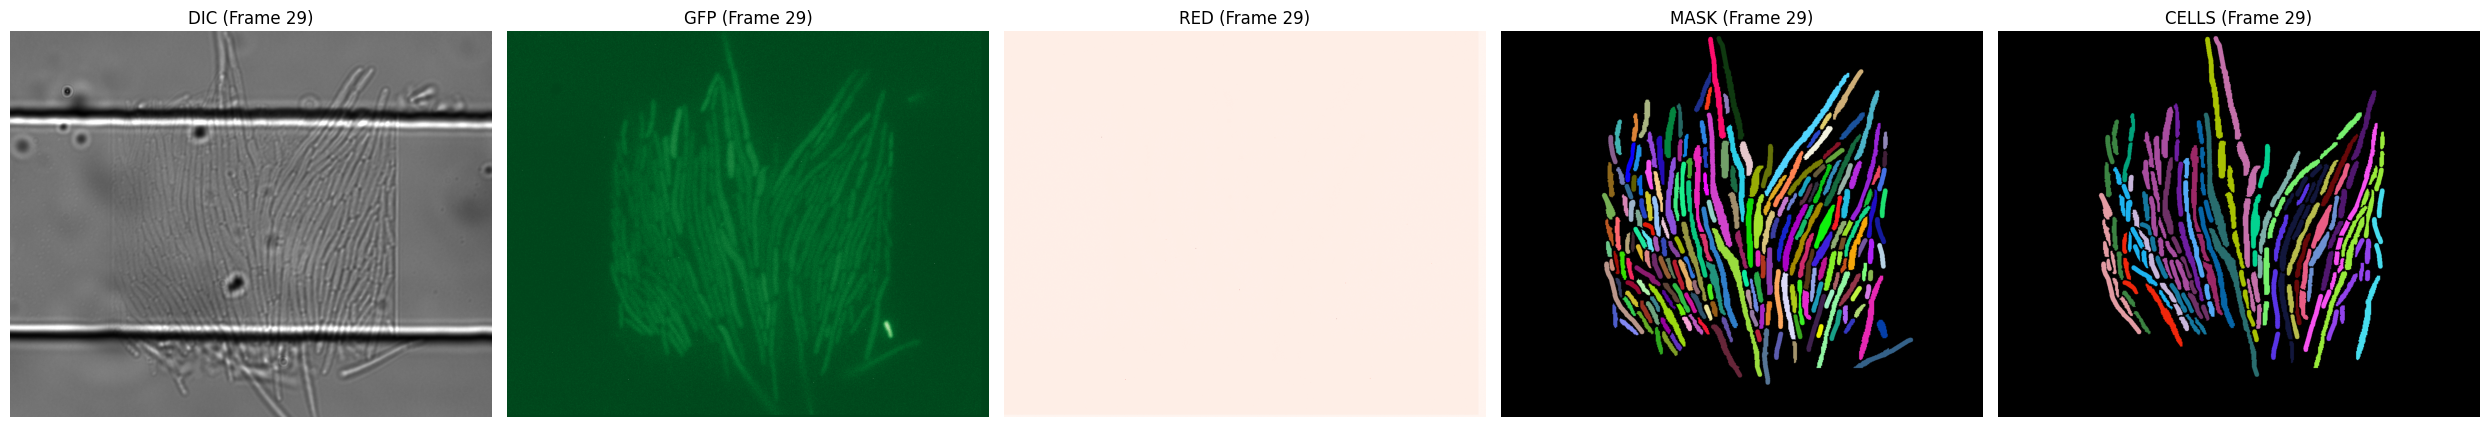

In [47]:

def plot_channels(images, frame_idx=0):
    """
    Plots the given frame from all available channels.

    Parameters:
        images (dict): Dictionary containing channel names as keys and multi-frame TIFs as values.
        frame_idx (int): Index of the frame to display.
    """
    # Define the expected order of channels for consistent plotting
    channel_order = ["DIC", "GFP", "RED", "MASK", "CELLS"]
    channel_cmappings = {
        "DIC": "gray",
        "GFP": "Greens_r",
        "RED": "Reds",
        "MASK": random_cmap,
        "CELLS": random_cmap,
    }

    # Select only channels that are present in the images dictionary
    available_channels = [ch for ch in channel_order if ch in images]

    # Create a figure with subplots
    fig, axes = plt.subplots(1, len(available_channels), figsize=(5 * len(available_channels), 5))

    if len(available_channels) == 1:
        axes = [axes]  # Ensure axes is iterable if there's only one channel

    # Plot each available channel
    for ax, channel in zip(axes, available_channels):
        img_stack = images[channel]

        if img_stack.ndim == 3:  # Multi-frame image
            frame_idx = min(frame_idx, img_stack.shape[0] - 1)
            img = img_stack[frame_idx]
        else:  # Single-frame image (unlikely in this case)
            img = img_stack

        # Ensure proper scaling for visualization
        img = img.astype(np.float32)
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)  # Normalize to [0,1]

        # Plot with the appropriate colormap
        ax.imshow(img, cmap=channel_cmappings[channel])
        ax.set_title(f"{channel} (Frame {frame_idx})")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

for frame_idx in frames_to_compare: #frames_to_analyze:
    plot_channels(images, frame_idx=frame_idx)


## Cell morphology analysis

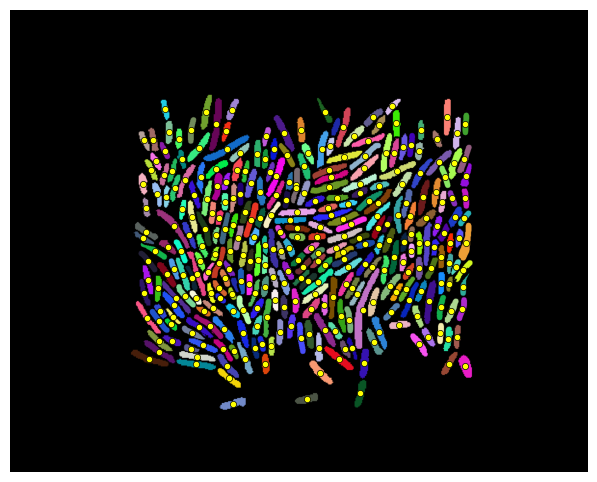

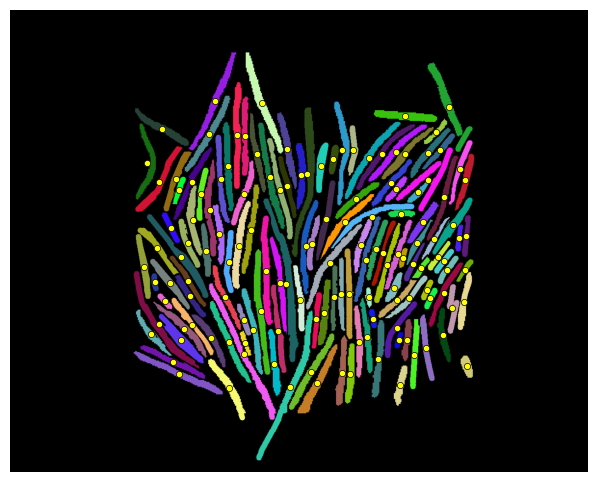

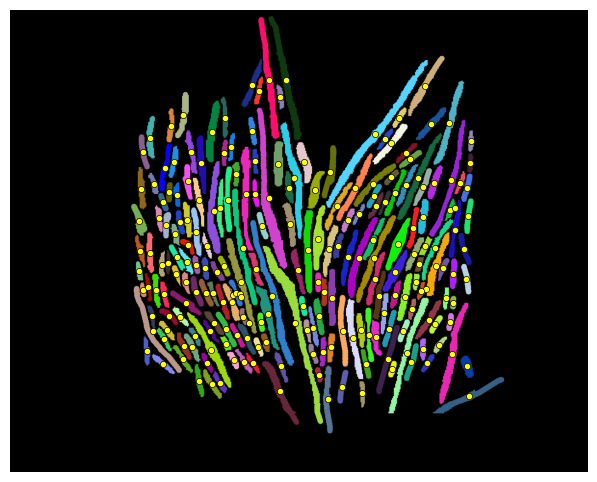

In [82]:


def get_cell_centers(mask):
    """
    Computes the center (centroid) of each segmented cell in the mask.

    Parameters:o
    - mask (np.ndarray): A 2D array where each unique value (excluding 0) represents a cell.

    Returns:
    - dict: A dictionary where keys are cell labels and values are (y, x) coordinates of the cell center.
    """
    unique_labels = np.unique(mask)
    unique_labels = unique_labels[unique_labels > 0]  # Exclude background (0)

    centers = {label: ndi.center_of_mass(mask == label) for label in unique_labels}

    return centers


def plot_cell_centers(mask, img, centers, point_color='yellow', point_size=20):
    """
    Plots the cell centers on top of the original image.

    Parameters:
    - mask (np.ndarray): The segmentation mask.
    - img (np.ndarray): The original grayscale image.
    - centers (dict): Dictionary of cell centers {label: (y, x)}.
    - point_color (str): Color of the points marking the centers.
    - point_size (int): Size of the center points.

    Returns:
    - None (Displays the plot)
    """
    fig, ax = plt.subplots(figsize=(8, 6))

    # Normalize and plot mask with a consistent colormap
    mask = mask.astype(np.float32)
    mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-6)  # Normalize

    ax.imshow(mask, cmap=random_cmap)  # Use consistent colormap for visualization

    # Overlay the cell centers
    for label, (y, x) in centers.items():
        ax.scatter(x, y, color=point_color, s=point_size, edgecolors='black', linewidth=0.5)

    ax.axis("off")  # Hide axes for cleaner visualization
    plt.show()


for frame_index in frames_to_analyze:
  # Extract the correct frame
  mask_frame = images['MASK'][frame_index] if 'MASK' in images and images['MASK'].ndim == 3 else images['MASK']
  dic_frame = images['DIC'][frame_index] if 'DIC' in images and images['DIC'].ndim == 3 else images['DIC']
  cell_centers = get_cell_centers(mask_frame)

  if frame_index in frames_to_compare:
    plot_cell_centers(mask_frame, dic_frame, cell_centers)


In [49]:


def compute_mask_area(mask):
    """
    Computes the area of each cell in the segmentation mask.

    Parameters:
    - mask (np.ndarray): Segmentation mask (each cell has a unique label).

    Returns:
    - dict: {cell_label: area (in pixels)}
    """
    mask_areas = {}

    for region in regionprops(mask):
        mask_areas[region.label] = region.area  # Count pixels within the region

    return mask_areas

def plot_mask_area_distribution(all_mask_areas):
    """
    Plots a histogram of the distribution of cell areas across multiple frames.

    Parameters:
    - all_mask_areas (list): A list containing all mask areas (in pixels²) from multiple frames.
    """
    plt.figure(figsize=(6, 4))
    plt.hist(all_mask_areas, bins=40, range=(0, 6000), edgecolor='black', alpha=0.75)
    plt.xlabel("Mask Area (pixels²)", fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()




Frame 0 - Mean Mask Area: 690.72 pixels², Std Dev: 246.53 pixels²
Frame 1 - Mean Mask Area: 693.02 pixels², Std Dev: 258.49 pixels²
Frame 2 - Mean Mask Area: 686.06 pixels², Std Dev: 363.19 pixels²
Frame 3 - Mean Mask Area: 674.39 pixels², Std Dev: 242.39 pixels²
Frame 4 - Mean Mask Area: 738.83 pixels², Std Dev: 249.18 pixels²
Frame 5 - Mean Mask Area: 708.46 pixels², Std Dev: 255.58 pixels²


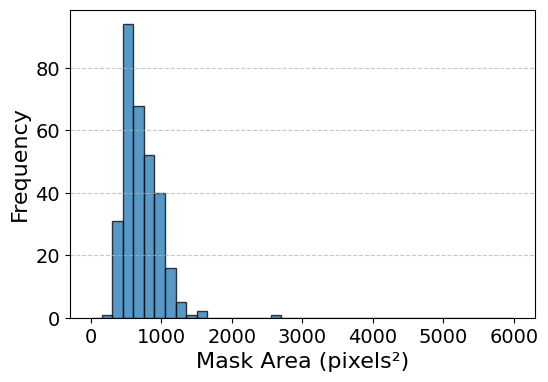

Frame 6 - Mean Mask Area: 721.33 pixels², Std Dev: 269.38 pixels²
Frame 7 - Mean Mask Area: 756.82 pixels², Std Dev: 283.70 pixels²
Frame 8 - Mean Mask Area: 713.85 pixels², Std Dev: 293.35 pixels²
Frame 9 - Mean Mask Area: 754.99 pixels², Std Dev: 310.47 pixels²
Frame 10 - Mean Mask Area: 793.12 pixels², Std Dev: 299.45 pixels²
Frame 11 - Mean Mask Area: 763.46 pixels², Std Dev: 297.60 pixels²
Frame 12 - Mean Mask Area: 756.29 pixels², Std Dev: 296.62 pixels²
Frame 13 - Mean Mask Area: 887.72 pixels², Std Dev: 387.48 pixels²
Frame 14 - Mean Mask Area: 1065.70 pixels², Std Dev: 531.90 pixels²
Frame 15 - Mean Mask Area: 1344.79 pixels², Std Dev: 628.02 pixels²
Frame 16 - Mean Mask Area: 1548.28 pixels², Std Dev: 696.40 pixels²
Frame 17 - Mean Mask Area: 1905.65 pixels², Std Dev: 923.48 pixels²


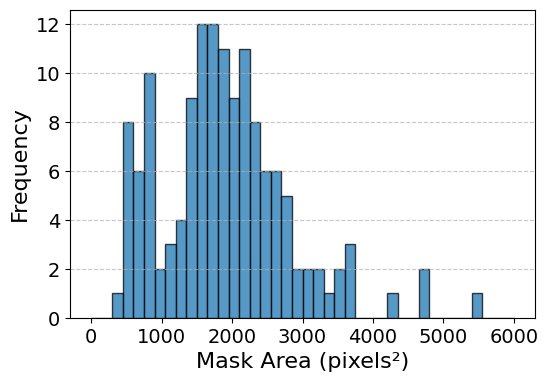

Frame 18 - Mean Mask Area: 2315.71 pixels², Std Dev: 1155.44 pixels²
Frame 19 - Mean Mask Area: 2603.60 pixels², Std Dev: 1396.75 pixels²
Frame 20 - Mean Mask Area: 2785.44 pixels², Std Dev: 1606.64 pixels²
Frame 21 - Mean Mask Area: 2990.07 pixels², Std Dev: 2176.26 pixels²
Frame 22 - Mean Mask Area: 2542.58 pixels², Std Dev: 2080.34 pixels²
Frame 23 - Mean Mask Area: 2099.78 pixels², Std Dev: 1622.88 pixels²
Frame 24 - Mean Mask Area: 1708.78 pixels², Std Dev: 1296.16 pixels²
Frame 25 - Mean Mask Area: 1505.40 pixels², Std Dev: 1266.03 pixels²
Frame 26 - Mean Mask Area: 1470.74 pixels², Std Dev: 1307.19 pixels²
Frame 27 - Mean Mask Area: 1383.21 pixels², Std Dev: 1304.63 pixels²
Frame 28 - Mean Mask Area: 1288.95 pixels², Std Dev: 1197.03 pixels²
Frame 29 - Mean Mask Area: 1149.32 pixels², Std Dev: 993.02 pixels²


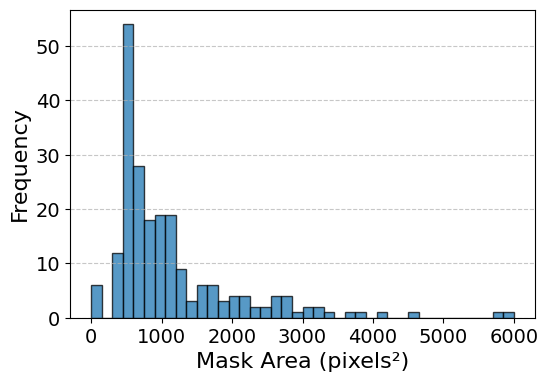

Frame 30 - Mean Mask Area: 975.42 pixels², Std Dev: 999.12 pixels²


In [50]:

# Store cell areas per frame
mask_area_dict = {}

for frame_idx in frames_to_analyze:
    if 'MASK' not in images or images['MASK'].ndim < 3:
        print(f"[ERROR] MASK layer is missing or not multi-frame.")
        continue

    # Extract the correct frame
    mask_frame = images['MASK'][frame_idx]

    #print(f"\n[INFO] Processing frame {frame_idx}")

    # Compute cell centers and plot them
    #cell_centers = get_cell_centers(mask_frame)
    #plot_cell_centers(mask_frame, mask_frame, cell_centers)

    # Compute cell areas
    mask_areas = compute_mask_area(mask_frame)
    area_values = list(mask_areas.values())

    # Store areas in dictionary for later comparison
    mask_area_dict[frame_idx] = area_values

    # Compute statistics
    mean_area = np.mean(area_values)
    std_area = np.std(area_values)

    print(f"Frame {frame_idx} - Mean Mask Area: {mean_area:.2f} pixels², Std Dev: {std_area:.2f} pixels²")

    # Plot area distribution
    if frame_idx in frames_to_compare:
        plot_mask_area_distribution(area_values)


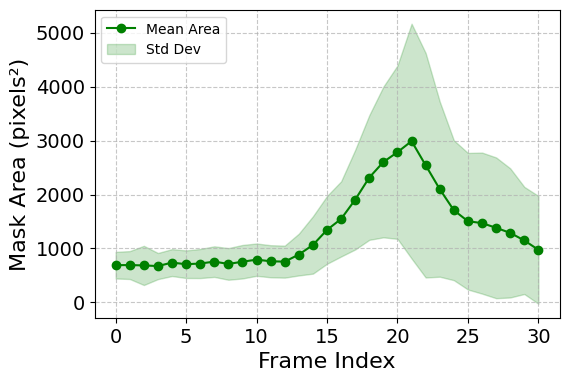

In [51]:


def plot_mask_area_vs_time(cell_area_dict):
    """
    Plots mean cell area vs. time, with error bars showing standard deviation.

    Parameters:
    - cell_area_dict (dict): {frame_index: list of cell areas}.
    """
    frames = sorted(cell_area_dict.keys())  # Get the sorted list of frames
    mean_areas = []
    std_areas = []

    for frame_idx in frames:
        areas = np.array(cell_area_dict[frame_idx])
        mean_areas.append(np.mean(areas))
        std_areas.append(np.std(areas))

    # Convert lists to NumPy arrays
    mean_areas = np.array(mean_areas)
    std_areas = np.array(std_areas)

    # Create time vs. mean area plot with shaded std deviation
    plt.figure(figsize=(6, 4))
    plt.plot(frames, mean_areas, marker='o', linestyle='-', color='green', label="Mean Area")
    plt.fill_between(frames, mean_areas - std_areas, mean_areas + std_areas,
                     color='green', alpha=0.2, label="Std Dev")

    plt.xlabel("Frame Index", fontsize=16)
    plt.ylabel("Mask Area (pixels²)", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Call the function after collecting cell_area_dict
if mask_area_dict:
    plot_mask_area_vs_time(mask_area_dict)


In [52]:


def visualize_skeleton(mask, skeleton):
    """
    Overlays the computed skeleton on the original mask.

    Parameters:
    - mask (np.ndarray): The original segmentation mask.
    - skeleton (np.ndarray): The skeletonized representation.
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(mask, cmap="gray", alpha=0.6)
    ax.imshow(skeleton, cmap="cool", alpha=0.8)  # Skeleton in blue

    ax.axis("off")
    plt.show()


In [53]:


def extract_axes(mask, smoothing_sigma=2, num_points=100, minor_length=10):
    """
    Extracts a smoothed major axis line and the minor axis of each cell.

    Parameters:
    - mask (np.ndarray): 2D segmentation mask where each unique value represents a cell.
    - smoothing_sigma (float): Standard deviation for Gaussian smoothing.
    - num_points (int): Number of points sampled along the smoothed axis.
    - minor_length (int): Length of the minor axis on each side of the center.

    Returns:
    - dict: {cell_id: {'axis': list of (y, x), 'center': (y, x), 'minor_axis': [(y1, x1), (y2, x2)]}}
    """
    axes_data = {}

    for region in regionprops(mask):
        cell_id = region.label
        cell_mask = (mask == cell_id)

        # Compute skeleton (centerline)
        skeleton = skeletonize(cell_mask)

        # Get all skeleton pixel coordinates
        skel_coords = np.column_stack(np.where(skeleton))

        if len(skel_coords) < 10:  # Need enough points for smoothing
            continue

        # **Build Minimum Spanning Tree (MST) to order points correctly**
        G = nx.Graph()
        for i, (y1, x1) in enumerate(skel_coords):
            for j, (y2, x2) in enumerate(skel_coords):
                if i != j:
                    distance = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
                    G.add_edge(i, j, weight=distance)

        mst = nx.minimum_spanning_tree(G)
        ordered_nodes = list(nx.dfs_preorder_nodes(mst, source=0))
        skel_coords = skel_coords[ordered_nodes]

        # Apply Gaussian smoothing
        smoothed_x = gaussian_filter1d(skel_coords[:, 1], sigma=smoothing_sigma)
        smoothed_y = gaussian_filter1d(skel_coords[:, 0], sigma=smoothing_sigma)

        # Apply Savitzky-Golay filter for further smoothing
        if len(smoothed_x) > 11:  # Need at least window size 11 for the filter
            smoothed_x = savgol_filter(smoothed_x, window_length=11, polyorder=2)
            smoothed_y = savgol_filter(smoothed_y, window_length=11, polyorder=2)

        # Fit a smooth B-spline curve
        try:
            tck, u = splprep([smoothed_x, smoothed_y], s=1.0, k=3)  # Adjust `s` for best fit
            u_fine = np.linspace(0, 1, num_points)
            final_x, final_y = splev(u_fine, tck)

            # Clip coordinates to ensure they stay within image bounds
            final_x = np.clip(final_x, 0, mask.shape[1] - 1)
            final_y = np.clip(final_y, 0, mask.shape[0] - 1)

            # Compute center point (midpoint of the smoothed axis)
            mid_idx = len(final_x) // 2
            center = (final_y[mid_idx], final_x[mid_idx])

            # Compute minor axis
            if 1 <= mid_idx < len(final_x) - 1:  # Avoid boundary issues
                dy = final_y[mid_idx + 1] - final_y[mid_idx - 1]
                dx = final_x[mid_idx + 1] - final_x[mid_idx - 1]
            else:  # If near the boundary, use single-sided difference
                dy = final_y[mid_idx] - final_y[mid_idx - 1]
                dx = final_x[mid_idx] - final_x[mid_idx - 1]

            # Compute perpendicular direction
            norm = np.sqrt(dx**2 + dy**2)
            if norm == 0:  # Avoid division by zero
                continue
            perp_dx = -dy / norm
            perp_dy = dx / norm

            # Compute endpoints of the minor axis
            y1, x1 = center[0] + minor_length * perp_dy, center[1] + minor_length * perp_dx
            y2, x2 = center[0] - minor_length * perp_dy, center[1] - minor_length * perp_dx

            # Store smoothed path, center, and minor axis
            axes_data[cell_id] = {
                'axis': list(zip(final_y, final_x)),
                'center': center,
                'minor_axis': [(y1, x1), (y2, x2)]
            }

        except Exception as e:
            print(f"[WARNING] Skipping cell {cell_id} due to spline fitting error: {e}")

    return axes_data




In [54]:


def plot_smoothed_axes_with_center(mask, smoothed_axes):
    """
    Overlays the extracted smoothed major and minor axes, along with their precomputed center points, on the segmentation MASK.

    Parameters:
    - mask (np.ndarray): The original segmentation mask.
    - smoothed_axes (dict): {cell_id: {'axis': list of (y, x), 'center': (y, x), 'minor_axis': [(y1, x1), (y2, x2)]}}.
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(mask, cmap="gray", alpha=0.6)  # Display MASK with transparency

    # Overlay smoothed major axes, minor axes, and centers
    for cell_id, data in smoothed_axes.items():
        path = np.array(data['axis'])  # Extract the smoothed major axis
        center_y, center_x = data['center']  # Extract the precomputed center point
        minor_axis = np.array(data['minor_axis'])  # Extract minor axis endpoints

        # **Plot the smoothed major axis (red)**
        ax.plot(path[:, 1], path[:, 0], color='red', linewidth=2)

        # **Plot the minor axis (blue, perpendicular to major axis)**
        ax.plot(minor_axis[:, 1], minor_axis[:, 0], color='blue', linewidth=2)

        # **Plot the center as a yellow dot**
        ax.scatter(center_x, center_y, color='yellow', edgecolors='black', s=15)

    plt.show()


In [55]:
def compute_cell_lengths(axes_data):
    """
    Computes the length of each cell from its major axis and converts it from pixels to µm.

    Parameters:
    - axes_data (dict): {mask_id: {'axis': list of (y, x) coordinates}}

    Returns:
    - dict: {mask_id: length in µm}
    """
    cell_lengths = {}
    for mask_id, data in axes_data.items():
        major_axis = np.array(data['axis'])
        if len(major_axis) > 1:
            length_pixels = np.linalg.norm(major_axis[0] - major_axis[-1])
            length_um = length_pixels / pixel2um  # Convert to micrometers
        else:
            length_um = np.nan  # If no valid axis, return NaN

        cell_lengths[mask_id] = length_um

    return cell_lengths  # Ensure it returns a dictionary {mask_id: length in µm}

In [56]:


def compute_cell_volumes(mask, smoothing_sigma=2, num_points=100):
    """
    Extracts smoothed major and minor axes, computes the center, and estimates the cell volume.

    Parameters:
    - mask (np.ndarray): 2D segmentation mask where each unique value represents a cell.
    - smoothing_sigma (float): Standard deviation for Gaussian smoothing.
    - num_points (int): Number of points sampled along the smoothed axis.

    Returns:
    - dict: {mask_id: volume in µm³}
    """
    cell_volumes = {}

    for region in regionprops(mask):
        mask_id = region.label
        cell_mask = (mask == mask_id)

        # Compute skeleton (centerline)
        skeleton = skeletonize(cell_mask)
        skel_coords = np.column_stack(np.where(skeleton))

        if len(skel_coords) < 10:  # Need enough points for smoothing
            continue

        # **Build Minimum Spanning Tree (MST) to order points correctly**
        G = nx.Graph()
        for i, (y1, x1) in enumerate(skel_coords):
            for j, (y2, x2) in enumerate(skel_coords):
                if i != j:
                    distance = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
                    G.add_edge(i, j, weight=distance)

        mst = nx.minimum_spanning_tree(G)
        ordered_nodes = list(nx.dfs_preorder_nodes(mst, source=0))
        skel_coords = skel_coords[ordered_nodes]

        # Apply Gaussian smoothing
        smoothed_x = gaussian_filter1d(skel_coords[:, 1], sigma=smoothing_sigma)
        smoothed_y = gaussian_filter1d(skel_coords[:, 0], sigma=smoothing_sigma)

        # Apply Savitzky-Golay filter for further smoothing
        if len(smoothed_x) > 11:
            smoothed_x = savgol_filter(smoothed_x, window_length=11, polyorder=2)
            smoothed_y = savgol_filter(smoothed_y, window_length=11, polyorder=2)

        # Fit a smooth B-spline curve
        try:
            tck, u = splprep([smoothed_x, smoothed_y], s=1.0, k=3)
            u_fine = np.linspace(0, 1, num_points)
            final_x, final_y = splev(u_fine, tck)

            # Clip coordinates to ensure they stay within image bounds
            final_x = np.clip(final_x, 0, mask.shape[1] - 1)
            final_y = np.clip(final_y, 0, mask.shape[0] - 1)

            # Compute center point
            mid_idx = len(final_x) // 2
            center = (final_y[mid_idx], final_x[mid_idx])

            # Compute minor axis (perpendicular at center)
            dx = final_x[-1] - final_x[0]
            dy = final_y[-1] - final_y[0]
            norm_factor = np.sqrt(dx**2 + dy**2)
            if norm_factor == 0:
                continue  # Avoid division by zero

            perp_dx = -dy / norm_factor
            perp_dy = dx / norm_factor
            minor_axis_length = region.minor_axis_length / 2  # Half-length

            minor_axis = [
                (center[0] - minor_axis_length * perp_dy, center[1] - minor_axis_length * perp_dx),
                (center[0] + minor_axis_length * perp_dy, center[1] + minor_axis_length * perp_dx)
            ]

            # Compute major and minor axis lengths in µm
            major_length = region.major_axis_length / pixel2um  # Convert pixels → µm
            radius = (minor_axis_length / 2) / pixel2um  # Convert pixels → µm

            # Estimate volume using the cylinder + hemisphere model
            volume_um3 = np.pi * (radius ** 2) * major_length + (4 / 3) * np.pi * (radius ** 3)

            # Store volume in dictionary with mask_id as key
            cell_volumes[mask_id] = volume_um3  # Store in µm³

        except Exception as e:
            print(f"[WARNING] Skipping mask_id {mask_id} due to spline fitting error: {e}")

    return cell_volumes  # Returns volumes in µm³


In [57]:


def compute_cell_surfacearea(smoothed_axes):
    """
    Computes the surface area of each cell assuming a cylindrical shape.

    Parameters:
    - smoothed_axes (dict): {mask_id: {'axis': list of (y, x), 'center': (y, x), 'minor_axis': float}}

    Returns:
    - dict: {mask_id: estimated surface area in µm²}
    """
    surface_areas = {}

    for mask_id, data in smoothed_axes.items():
        if "axis" in data and "minor_axis" in data:
            # Compute the major axis length in µm
            major_axis_length = np.linalg.norm(
                np.array(data['axis'][0]) - np.array(data['axis'][-1])
            ) / pixel2um  # Convert pixels → µm

            # Extract minor axis length and convert to µm
            minor_axis_length = data["minor_axis"]  # Estimated minor axis (diameter)

            # Handle case where minor_axis is a list (take mean value)
            if isinstance(minor_axis_length, list):
                minor_axis_length = np.mean(minor_axis_length)

            radius = (minor_axis_length / 2) / pixel2um  # Convert pixels → µm

            # Compute surface area assuming a cylindrical shape (in µm²)
            surface_area_um2 = (
                2 * np.pi * radius * major_axis_length +  # Lateral surface
                2 * np.pi * radius**2  # Two end caps
            )

            # Store result in dictionary with mask_id as key
            surface_areas[mask_id] = surface_area_um2  # Store in µm²

    return surface_areas  # Return as {mask_id: surface_area in µm²}


In [58]:


def plot_surface_area_distribution(cell_surface_areas, bins=40, range_max=2e6):
    """
    Computes and plots a histogram of cell surface areas.

    Parameters:
    - surface_area_values
    - bins (int): Number of bins for the histogram.
    - range_max (float): Maximum value on the x-axis.

    Returns:
    - None (Displays the plot)
    """


    # Plot histogram
    plt.figure(figsize=(6, 4))
    plt.hist(cell_surface_areas, bins=bins, range=(0, range_max), edgecolor='black', alpha=0.75)
    plt.xlabel("Surface Area (pixels²)", fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


def plot_volume_distribution(cell_volumes, bins=40, range_max=1e6):
    """
    Plots a histogram of the distribution of estimated cell volumes.

    Parameters:
    - cell_info (dict): {cell_id: {'volume': V}}.
    """

    plt.figure(figsize=(6, 4))
    plt.hist(cell_volumes, bins=bins, range=(0, range_max), edgecolor='black', alpha=0.75)
    plt.xlabel("Cell Volume (pixels³)", fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.title("Distribution of Cell Volumes")
    plt.show()

def plot_cell_length_distribution(cell_lengths, bins=40, range_max=1000):
    """
    Computes and plots a histogram of cell lengths.

    Parameters:
    - cell_lengths (list): List of estimated cell lengths (in pixels or µm).
    - bins (int): Number of bins for the histogram.
    - range_max (float): Maximum value on the x-axis.

    Returns:
    - None (Displays the plot)
    """
    # Plot histogram
    plt.figure(figsize=(6, 4))
    plt.hist(cell_lengths, bins=bins, range=(0, range_max), edgecolor='black', alpha=0.75)
    plt.xlabel("Cell Length (µm)", fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()



def plot_length_vs_sa_v_contour(lengths, surface_areas, volumes, length_max, sav_max, bins=50, cmap="Blues"):
    """
    Plots a 2D contour plot showing the joint distribution of cell length vs. SA/V ratio.

    Parameters:
    - lengths (list or np.ndarray): List of computed cell lengths.
    - surface_areas (list or np.ndarray): List of computed cell surface areas.
    - volumes (list or np.ndarray): List of computed cell volumes.
    - bins (int): Number of bins for histogram density estimation.
    """

    # Convert to NumPy arrays
    lengths = np.array(lengths)
    surface_areas = np.array(surface_areas)
    volumes = np.array(volumes)

    # Compute SA/V ratio
    sa_v_ratio = surface_areas / volumes  # Ensure proper division

    # Define the grid for the contour plot
    x_bins = np.linspace(min(lengths), max(lengths), bins)
    y_bins = np.linspace(min(sa_v_ratio), max(sa_v_ratio), bins)

    # Plot the contour map
    plt.figure(figsize=(6,4))
    sns.kdeplot(x=lengths, y=sa_v_ratio, cmap=cmap, fill=True, levels=20)
    plt.xlabel("Cell Length (µm)", fontsize=20)
    plt.ylabel("SA/V (µm⁻¹)", fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(alpha=0.3)
    plt.xlim([0, length_max])
    plt.ylim([0, sav_max])

    plt.show()





In [59]:



def save_axes(mask, mask_filename, output_dir, pkl_file):
    """
    Extracts and saves smoothed major and minor axes data with centers,
    along with mask IDs, lengths, volumes, surface areas, and assigned colors.

    Parameters:
    - mask (np.ndarray): The original segmentation mask.
    - mask_filename (str): The filename of the MASK image.
    - output_dir (str): Directory where the PKL file will be saved.
    - pkl_file (str): Output filename for the PKL file.

    Returns:
    - None (saves the file)
    """
    # Extract smoothed axes with centers and minor axes
    axes_data = extract_axes(mask)

    # **Compute additional properties**
    cell_lengths = compute_cell_lengths(axes_data)  # {mask_id: length}
    cell_volumes = compute_cell_volumes(mask)  # {mask_id: volume}
    cell_surface_areas = compute_cell_surfacearea(axes_data)  # {mask_id: surface_area}

    # **Generate consistent colors for each mask_id**
    mask_ids = list(axes_data.keys())
    cell_colors = generate_consistent_colors(mask_ids)  # {mask_id: (R, G, B)}

    # Attach properties to each cell in `axes_data`
    updated_data = {}

    for mask_id in axes_data.keys():
        updated_data[mask_id] = {
            'mask_id': mask_id,  # Explicitly store the mask ID
            'axis': axes_data[mask_id]['axis'],
            'center': axes_data[mask_id]['center'],
            'minor_axis': axes_data[mask_id]['minor_axis'],
            'length': cell_lengths.get(mask_id, np.nan),
            'volume': cell_volumes.get(mask_id, np.nan),
            'surface_area': cell_surface_areas.get(mask_id, np.nan),
            'color': cell_colors[mask_id]  # Store the consistent color
        }

    # Store the MASK itself in the PKL file
    full_data = {
        "mask": mask,  # Store the full MASK array
        "cells": updated_data
    }

    # Generate output filename
    output_path = os.path.join(output_dir, pkl_file)

    # Save as PKL file
    with open(output_path, 'wb') as f:
        pickle.dump(full_data, f)

    print(f"[INFO] Saved smoothed axes data + MASK + Colors to {output_path}")


In [60]:
analyze_images=False
if analyze_images:
  for frame_index in frames_to_analyze:
    mask_filename = "%s_MASK.tif"%experiment_id  # Change to your actual filename

    # Extract MASK from the selected frame
    mask_frame = images['MASK'][frame_index]

    #cell_volumes = compute_cell_volume(mask_frame)
    skeleton = skeletonize(mask_frame > 0)  # Get global skeleton for visualization

    # Visualize skeleton overlay
    visualize_skeleton(mask_frame, skeleton)

    pkl_file = "%s%s_frame%s.pkl"%(output_directory,experiment_id,frame_index)

    # **Save smoothed major axis paths + centers + minor axes**
    save_axes(mask_frame, mask_filename, output_directory, pkl_file)


In [61]:


frame_lengths = []
frame_volumes = []
frame_surface_areas = []
mask_ids_per_frame = []
frame_masks = []  # Store MASKs per frame

for frame_index in frames_to_analyze:
    print(f"[INFO] Processing frame {frame_index}")

    pkl_file = f"{output_directory}/{experiment_id}_frame{frame_index}.pkl"

    # **Load the saved data (including MASK)**
    with open(pkl_file, "rb") as f:
        loaded_data = pickle.load(f)

    # Extract stored MASK
    mask = loaded_data["mask"]
    frame_masks.append(mask)  # Store for later use

    # Extract stored cell data
    smoothed_axes = loaded_data["cells"]

    #plot_smoothed_axes_with_center(mask, smoothed_axes)
    cmap="Blues"
    if 11 < frame_index < 18:
      cmap="Reds"

    # Extract precomputed values
    mask_ids = [data['mask_id'] for data in smoothed_axes.values()]
    cell_lengths = [data['length'] for data in smoothed_axes.values()]
    cell_volumes = [data['volume'] for data in smoothed_axes.values()]
    cell_surface_areas = [data['surface_area'] for data in smoothed_axes.values()]

    # Store for later analysis

    frame_lengths.append(cell_lengths)
    frame_volumes.append(cell_volumes)
    frame_surface_areas.append(cell_surface_areas)
    mask_ids_per_frame.append(mask_ids)

    #Plot distributions
    if frame_index == frames_to_compare:
        plot_cell_length_distribution(cell_lengths, bins=40, range_max=ylim_length)
        plot_volume_distribution(cell_volumes, bins=40, range_max=ylim_volume)
        plot_surface_area_distribution(cell_surface_areas, bins=40, range_max=ylim_surface_area)
        plot_length_vs_sa_v_contour(cell_lengths, cell_surface_areas, cell_volumes, length_max=ylim_length, sav_max=ylim_sav, cmap=cmap)



[INFO] Processing frame 0
[INFO] Processing frame 1
[INFO] Processing frame 2
[INFO] Processing frame 3
[INFO] Processing frame 4
[INFO] Processing frame 5
[INFO] Processing frame 6
[INFO] Processing frame 7
[INFO] Processing frame 8
[INFO] Processing frame 9
[INFO] Processing frame 10
[INFO] Processing frame 11
[INFO] Processing frame 12
[INFO] Processing frame 13
[INFO] Processing frame 14
[INFO] Processing frame 15
[INFO] Processing frame 16
[INFO] Processing frame 17
[INFO] Processing frame 18
[INFO] Processing frame 19
[INFO] Processing frame 20
[INFO] Processing frame 21
[INFO] Processing frame 22
[INFO] Processing frame 23
[INFO] Processing frame 24
[INFO] Processing frame 25
[INFO] Processing frame 26
[INFO] Processing frame 27
[INFO] Processing frame 28
[INFO] Processing frame 29
[INFO] Processing frame 30


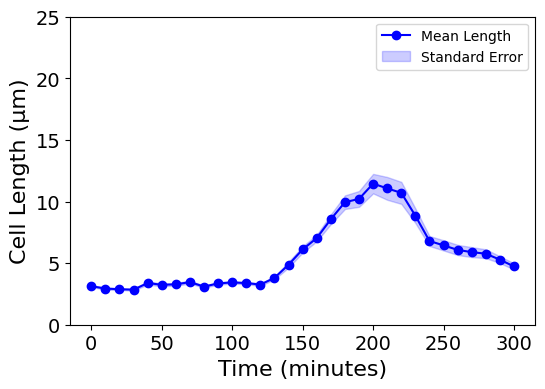

In [62]:
def plot_cell_length_vs_time(frames_to_analyze, frame_lengths, ylim):
    """
    Plots mean cell length vs. time (in minutes), with error bars showing standard error.

    Parameters:
    - frames_to_analyze (list): List of frame indices.
    - frame_lengths (list of lists): Each entry contains a list of cell lengths for a frame.
    - ylim (float): Upper limit for the y-axis.
    """

    mean_lengths = []
    sem_lengths = []

    for lengths in frame_lengths:
        lengths = np.array(lengths)

        if len(lengths) > 0:
            mean_lengths.append(np.mean(lengths))
            sem_lengths.append(np.std(lengths) / np.sqrt(len(lengths)))  # Compute SEM
        else:
            mean_lengths.append(np.nan)
            sem_lengths.append(np.nan)

    # Convert frames to minutes
    time_in_minutes = np.array(frames_to_analyze) * frame2min

    # Convert lists to NumPy arrays
    mean_lengths = np.array(mean_lengths)
    sem_lengths = np.array(sem_lengths)

    # Create time vs. mean length plot with shaded standard error
    plt.figure(figsize=(6, 4))
    plt.plot(time_in_minutes, mean_lengths, marker='o', linestyle='-', color='blue', label="Mean Length")
    plt.fill_between(time_in_minutes, mean_lengths - sem_lengths, mean_lengths + sem_lengths,
                     color='blue', alpha=0.2, label="Standard Error")

    plt.xlabel("Time (minutes)", fontsize=16)  # Updated X-axis label
    plt.ylabel("Cell Length (µm)", fontsize=16)  # Updated Y-axis label
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.)
    plt.ylim([0, ylim])  # Ensures proper scaling
    plt.show()


# Call the function
plot_cell_length_vs_time(frames_to_analyze, frame_lengths, ylim=ylim_length)


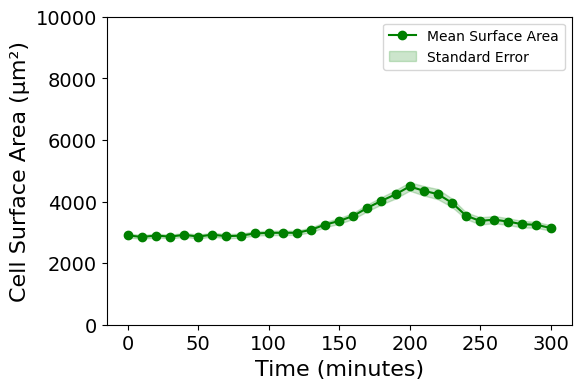

In [63]:
def plot_surface_area_vs_time(frames_to_analyze, frame_surface_areas, ylim):
    """
    Plots mean cell surface area vs. time (in minutes), with error bars showing standard error.

    Parameters:
    - frames_to_analyze (list): List of frame indices.
    - frame_surface_areas (list of lists): Each entry contains a list of cell surface areas for a frame.
    - ylim (float): Upper limit for the y-axis.
    """

    mean_surface_areas = []
    sem_surface_areas = []

    for areas in frame_surface_areas:
        areas = np.array(areas)

        if len(areas) > 0:
            mean_surface_areas.append(np.mean(areas))
            sem_surface_areas.append(np.std(areas) / np.sqrt(len(areas)))  # Compute SEM
        else:
            mean_surface_areas.append(np.nan)
            sem_surface_areas.append(np.nan)

    # Convert frames to minutes
    time_in_minutes = np.array(frames_to_analyze) * frame2min

    # Convert lists to NumPy arrays
    mean_surface_areas = np.array(mean_surface_areas)
    sem_surface_areas = np.array(sem_surface_areas)

    # Create time vs. mean surface area plot with shaded standard error
    plt.figure(figsize=(6, 4))
    plt.plot(time_in_minutes, mean_surface_areas, marker='o', linestyle='-', color='green', label="Mean Surface Area")
    plt.fill_between(time_in_minutes, mean_surface_areas - sem_surface_areas, mean_surface_areas + sem_surface_areas,
                     color='green', alpha=0.2, label="Standard Error")

    plt.xlabel("Time (minutes)", fontsize=16)  # Updated X-axis label
    plt.ylabel("Cell Surface Area (µm²)", fontsize=16)  # Y-axis remains unchanged
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.0)
    plt.ylim([0, ylim])
    plt.show()


# Call the function
plot_surface_area_vs_time(frames_to_analyze, frame_surface_areas, ylim=ylim_surface_area)


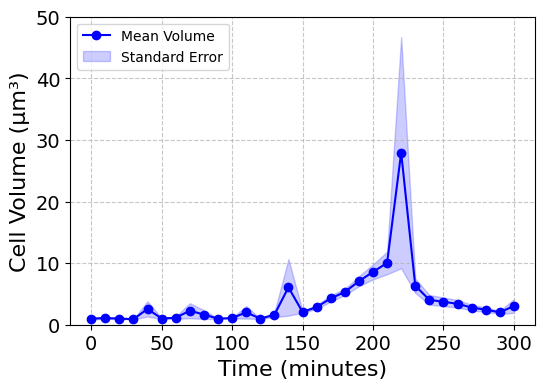

In [64]:
def plot_volume_vs_time(frames_to_analyze, frame_volumes, ylim):
    """
    Plots mean cell volume vs. time (in minutes), with error bars showing standard error.

    Parameters:
    - frames_to_analyze (list): List of frame indices.
    - frame_volumes (list of lists): Each entry contains a list of cell volumes for a frame.
    - ylim (float): Upper limit for the y-axis.
    """

    mean_volumes = []
    sem_volumes = []

    for volumes in frame_volumes:
        volumes = np.array(volumes)

        if len(volumes) > 0:
            mean_volumes.append(np.mean(volumes))
            sem_volumes.append(np.std(volumes) / np.sqrt(len(volumes)))  # Compute SEM
        else:
            mean_volumes.append(np.nan)
            sem_volumes.append(np.nan)

    # Convert frames to minutes
    time_in_minutes = np.array(frames_to_analyze) * frame2min

    # Convert lists to NumPy arrays
    mean_volumes = np.array(mean_volumes)
    sem_volumes = np.array(sem_volumes)

    # Create time vs. mean volume plot with shaded standard error
    plt.figure(figsize=(6, 4))
    plt.plot(time_in_minutes, mean_volumes, marker='o', linestyle='-', color='blue', label="Mean Volume")
    plt.fill_between(time_in_minutes, mean_volumes - sem_volumes, mean_volumes + sem_volumes,
                     color='blue', alpha=0.2, label="Standard Error")

    plt.xlabel("Time (minutes)", fontsize=16)  # Updated X-axis label
    plt.ylabel("Cell Volume (µm³)", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim([0, ylim])  # Ensures proper scaling
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()


# Call the function
plot_volume_vs_time(frames_to_analyze, frame_volumes, ylim=ylim_volume)


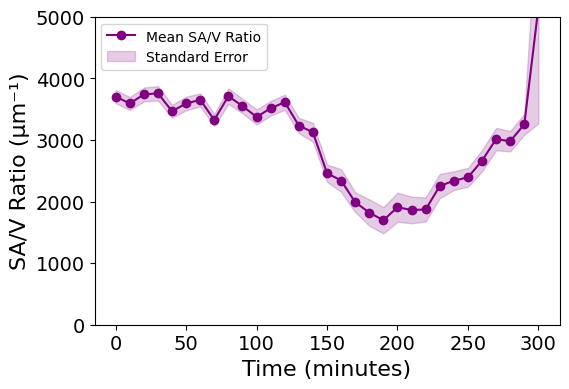

In [65]:
ylim_sav = 5e3  # Plotting limits (SA/V)

def plot_sa_volume_ratio_vs_time(frames_to_analyze, frame_surface_areas, frame_volumes, ylim):
    """
    Plots the mean SA/V ratio vs. time (in minutes), with error bars showing standard error.

    Parameters:
    - frames_to_analyze (list): List of frame indices.
    - frame_surface_areas (list of lists): Each entry contains a list of cell surface areas for a frame.
    - frame_volumes (list of lists): Each entry contains a list of cell volumes for a frame.
    - ylim (float): Upper limit for the y-axis.
    """

    sa_v_ratios = []
    sem_sa_v_ratios = []

    for sa, vol in zip(frame_surface_areas, frame_volumes):
        sa = np.array(sa)
        vol = np.array(vol)

        # Ensure same length by truncating to the shortest list
        min_length = min(len(sa), len(vol))
        sa = sa[:min_length]
        vol = vol[:min_length]

        # Avoid division by zero errors
        valid_indices = vol > 0
        if np.any(valid_indices):
            ratio = sa[valid_indices] / vol[valid_indices]
            mean_ratio = np.mean(ratio)
            sem_ratio = np.std(ratio) / np.sqrt(len(ratio))  # Compute SEM

            sa_v_ratios.append(mean_ratio)
            sem_sa_v_ratios.append(sem_ratio)
        else:
            sa_v_ratios.append(np.nan)
            sem_sa_v_ratios.append(np.nan)

    # Convert frames to minutes
    time_in_minutes = np.array(frames_to_analyze) * frame2min

    # Convert lists to NumPy arrays
    sa_v_ratios = np.array(sa_v_ratios)
    sem_sa_v_ratios = np.array(sem_sa_v_ratios)

    # Create time vs. SA/V ratio plot with shaded standard error
    plt.figure(figsize=(6, 4))
    plt.plot(time_in_minutes, sa_v_ratios, marker='o', linestyle='-', color='purple', label="Mean SA/V Ratio")
    plt.fill_between(time_in_minutes, sa_v_ratios - sem_sa_v_ratios, sa_v_ratios + sem_sa_v_ratios,
                     color='purple', alpha=0.2, label="Standard Error")

    plt.xlabel("Time (minutes)", fontsize=16)
    plt.ylabel("SA/V Ratio (µm⁻¹)", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend()
    plt.ylim([0, ylim])  # Ensures proper scaling
    plt.grid(True, linestyle='--', alpha=0.)
    plt.show()

# Call the function
plot_sa_volume_ratio_vs_time(frames_to_analyze, frame_surface_areas, frame_volumes, ylim=ylim_sav)




---
## Single-cell analysis




In [85]:

def get_cell_data_by_id(cell_id, frame_index, images, output_dir, experiment_id):
    """
    Retrieves the stored data for a given cell_id and frame_index from the PKL file.

    Parameters:
    - cell_id (int): The cell ID to retrieve data for.
    - frame_index (int): The frame index to retrieve data from.
    - images (dict): Dictionary containing 'MASK' and 'CELLS' channels.
    - output_dir (str): Directory where PKL files are stored.
    - experiment_id (str): Experiment identifier used in filenames.

    Returns:
    - dict: The retrieved data for the given cell_id (if found), else None.
    """

    # **Step 1: Get the corresponding `mask_id` from `cell_id`**
    cells_frame = images['CELLS'][frame_index]
    mask_frame = images['MASK'][frame_index]

    # Find the corresponding mask ID(s) for the given cell ID
    mask_ids = np.unique(mask_frame[cells_frame == cell_id])
    mask_ids = mask_ids[mask_ids > 0]  # Remove background (0)

    if len(mask_ids) == 0:
        #print(f"[WARNING] No matching mask_id found for cell_id {cell_id} in frame {frame_index}.")
        return None

    # **Assume the first mask_id found corresponds to this cell**
    mask_id = mask_ids[0]

    # **Step 2: Load PKL file**
    pkl_file = os.path.join(output_dir, f"{experiment_id}_frame{frame_index}.pkl")

    if not os.path.exists(pkl_file):
        print(f"[ERROR] File not found: {pkl_file}")
        return None

    with open(pkl_file, "rb") as f:
        loaded_data = pickle.load(f)

    # **Step 3: Retrieve stored data for `mask_id`**
    cell_data = loaded_data["cells"].get(mask_id, None)

    if cell_data is None:
        print(f"[WARNING] Mask ID {mask_id} (from Cell ID {cell_id}) not found in frame {frame_index}.")
    #else:
    #    print(f"[INFO] Found data for Cell {cell_id} (Mask {mask_id}) in Frame {frame_index}.")

    return cell_data



In [67]:

def get_cell_ids(images):
    """
    Returns a list of unique cell IDs from the CELLS layer.

    Parameters:
    - images (dict): Dictionary containing different image channels, including 'CELLS'.

    Returns:
    - list: Sorted list of unique cell IDs.
    """
    if 'CELLS' not in images:
        print("[ERROR] 'CELLS' channel not found in images.")
        return []

    # Extract the CELLS layer
    cells_layer = images['CELLS']

    # Get unique cell IDs, excluding background (0)
    unique_cell_ids = np.unique(cells_layer)
    unique_cell_ids = unique_cell_ids[unique_cell_ids > 0]  # Exclude background (0)

    return sorted(unique_cell_ids)

cell_ids = get_cell_ids(images)
#print(f"[INFO] Found {len(cell_ids)} unique cells:", cell_ids)


In [68]:
def track_cell(cell_id, frames_to_analyze, images, output_dir, experiment_id):
    """
    Tracks a given cell_id over multiple frames and retrieves its center, length,
    surface area, volume, and color over time.

    Parameters:
    - cell_id (int): The cell ID to track.
    - frames_to_analyze (list): List of frame indices to analyze.
    - images (dict): Dictionary containing 'MASK' and 'CELLS' channels.
    - output_dir (str): Directory where PKL files are stored.
    - experiment_id (str): Experiment identifier used in filenames.

    Returns:
    - dict: {'centers': list, 'lengths': list, 'surface_areas': list, 'volumes': list, 'color': tuple}
    """

    # Initialize lists to store data over time
    cell_centers = []
    cell_lengths = []
    cell_surface_areas = []
    cell_volumes = []
    cell_color = None  # Store color for consistency

    for frame_index in frames_to_analyze:
        # Retrieve cell data for the given frame
        cell_info = get_cell_data_by_id(cell_id, frame_index, images, output_dir, experiment_id)

        if cell_info:
            #print(f"\n[INFO] Data for cell_id {cell_id} in Frame {frame_index}:")
            #for key, value in cell_info.items():
            #    print(f"  {key}: {value}")

            # Append extracted values
            cell_centers.append(cell_info.get('center', (np.nan, np.nan)))
            cell_lengths.append(cell_info.get('length', np.nan))
            cell_surface_areas.append(cell_info.get('surface_area', np.nan))
            cell_volumes.append(cell_info.get('volume', np.nan))

            # Store color (only need to retrieve once)
            if cell_color is None:
                cell_color = cell_info.get('color', (0, 0, 0))  # Default black if not found
        else:
            # If cell not found, append NaN values
            cell_centers.append((np.nan, np.nan))
            cell_lengths.append(np.nan)
            cell_surface_areas.append(np.nan)
            cell_volumes.append(np.nan)

    # Return collected data as a dictionary
    return {
        'centers': cell_centers,
        'lengths': cell_lengths,
        'surface_areas': cell_surface_areas,
        'volumes': cell_volumes,
        'color': cell_color  # Return the stored color
    }



In [86]:
tracked_cells_data = {}

for cell_id in cell_ids:
    #print(f"\n[INFO] Tracking cell {cell_id}...")
    tracked_data = track_cell(cell_id, frames_to_analyze, images, output_directory, experiment_id)

    # Store all properties in the same dictionary entry
    tracked_cells_data[cell_id] = {
        'surface_areas': tracked_data['surface_areas'],
        'lengths': tracked_data['lengths'],
        'volumes': tracked_data['volumes'],
        'color': tracked_data['color']  # Store consistent cell color
    }


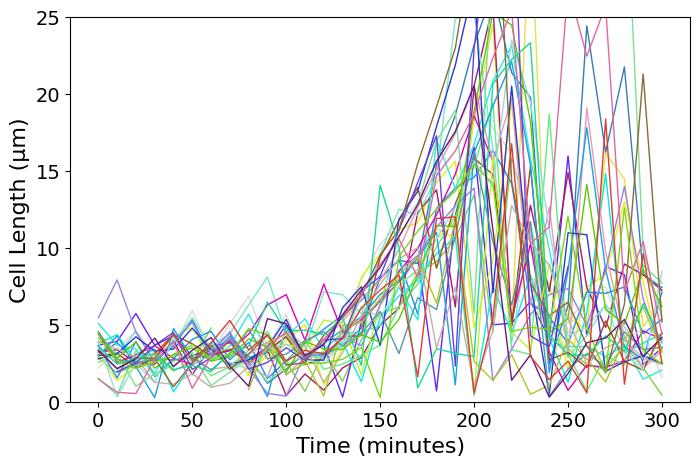

In [87]:


def plot_all_cells_length(frames_to_analyze, tracked_cells_data, ylim):
    """
    Plots cell length over time for multiple cells in the same plot, using stored colors.

    Parameters:
    - frames_to_analyze (list): List of frame indices.
    - tracked_cells_data (dict): {cell_id: {'lengths': list of values over time, 'color': (R, G, B)}}
    """

    plt.figure(figsize=(8, 5))

    # Convert frames to time in minutes
    time_in_minutes = np.array(frames_to_analyze) * frame2min

    for cell_id, data in tracked_cells_data.items():
        lengths = np.array(data['lengths'])
        color = data['color']  # Retrieve stored color

        plt.plot(time_in_minutes, lengths, lw=1, linestyle='-', color=color, label=f"Cell {cell_id}")

    plt.xlabel("Time (minutes)", fontsize=16)  # Updated X-axis label
    plt.ylabel("Cell Length (µm)", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.)
    plt.ylim([0, ylim])

    plt.show()

# **Plot All Tracked Cells**
plot_all_cells_length(frames_to_analyze, tracked_cells_data, ylim=ylim_length)


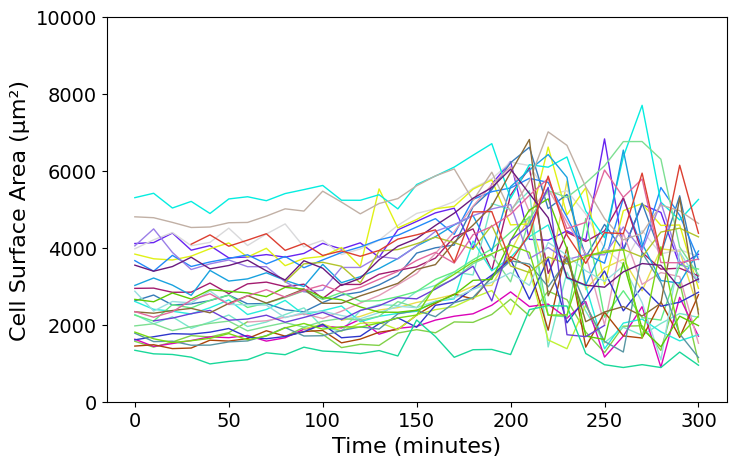

In [71]:


def plot_all_cells_surface_area(frames_to_analyze, tracked_cells_data, ylim):
    """
    Plots surface area over time for multiple cells in the same plot, using stored colors.

    Parameters:
    - frames_to_analyze (list): List of frame indices.
    - tracked_cells_data (dict): {cell_id: {'surface_areas': list of values over time, 'color': (R, G, B)}}
    """

    plt.figure(figsize=(8, 5))

    # Convert frames to time in minutes
    time_in_minutes = np.array(frames_to_analyze) * frame2min

    for cell_id, data in tracked_cells_data.items():
        surface_areas = np.array(data['surface_areas'])
        color = data['color']  # Retrieve stored color

        plt.plot(time_in_minutes, surface_areas, linestyle='-', lw=1, color=color, label=f"Cell {cell_id}")

    plt.xlabel("Time (minutes)", fontsize=16)  # Updated X-axis label
    plt.ylabel("Cell Surface Area (µm²)", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.)
    plt.ylim([0, ylim])

    plt.show()

# **Plot All Tracked Cells**
plot_all_cells_surface_area(frames_to_analyze, tracked_cells_data, ylim=ylim_surface_area)


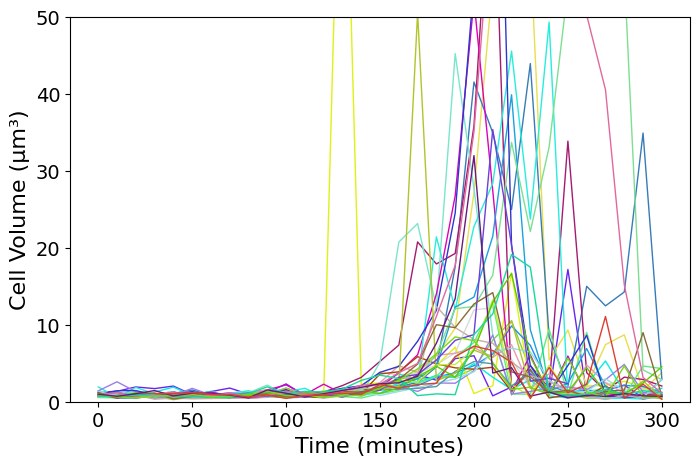

In [72]:

def plot_all_cells_volume(frames_to_analyze, tracked_cells_data, ylim):
    """
    Plots cell volume over time for multiple cells in the same plot, using stored colors.

    Parameters:
    - frames_to_analyze (list): List of frame indices.
    - tracked_cells_data (dict): {cell_id: {'volumes': list of values over time, 'color': (R, G, B)}}
    """

    plt.figure(figsize=(8, 5))

    # Convert frames to time in minutes
    time_in_minutes = np.array(frames_to_analyze) * frame2min

    for cell_id, data in tracked_cells_data.items():
        volumes = np.array(data['volumes'])
        color = data['color']  # Retrieve stored color

        plt.plot(time_in_minutes, volumes, lw=1, linestyle='-', color=color, label=f"Cell {cell_id}")

    plt.xlabel("Time (minutes)", fontsize=16)  # Updated X-axis label
    plt.ylabel("Cell Volume (µm³)", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.)
    plt.ylim([0, ylim])

    plt.show()

# **Plot All Tracked Cells**
plot_all_cells_volume(frames_to_analyze, tracked_cells_data, ylim=ylim_volume)


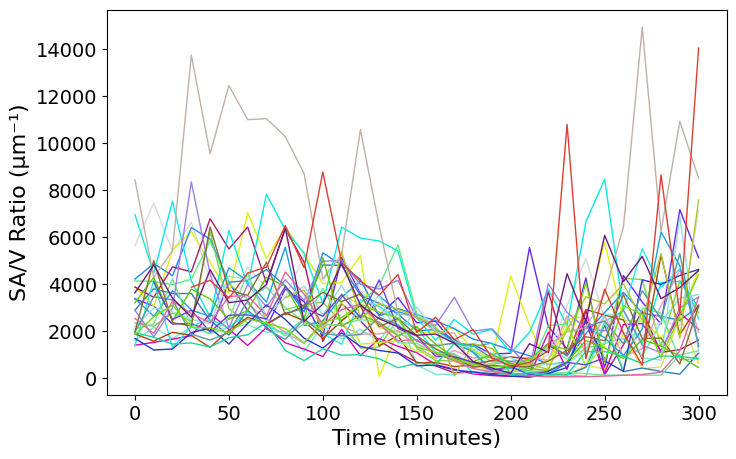

In [73]:

def plot_all_cells_sa_v_ratio(frames_to_analyze, tracked_cells_data):
    """
    Plots SA/V ratio over time for multiple cells in the same plot, using stored colors.

    Parameters:
    - frames_to_analyze (list): List of frame indices.
    - tracked_cells_data (dict): {cell_id: {'surface_areas': [...], 'volumes': [...], 'color': (R, G, B)}}
    """

    plt.figure(figsize=(8, 5))

    # Convert frames to time in minutes
    time_in_minutes = np.array(frames_to_analyze) * frame2min

    for cell_id, data in tracked_cells_data.items():
        surface_areas = np.array(data['surface_areas'])
        volumes = np.array(data['volumes'])

        # Compute SA/V Ratio (Avoid division by zero)
        sa_v_ratios = np.where(volumes > 0, surface_areas / volumes, np.nan)

        # Retrieve the stored color
        color = data['color']

        plt.plot(time_in_minutes, sa_v_ratios, lw=1, linestyle='-', color=color, label=f"Cell {cell_id}")

    plt.xlabel("Time (minutes)", fontsize=16)  # Updated X-axis label
    plt.ylabel("SA/V Ratio (µm⁻¹)", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.)

    plt.show()

# **Plot All Cells' SA/V Ratio**
plot_all_cells_sa_v_ratio(frames_to_analyze, tracked_cells_data)




---



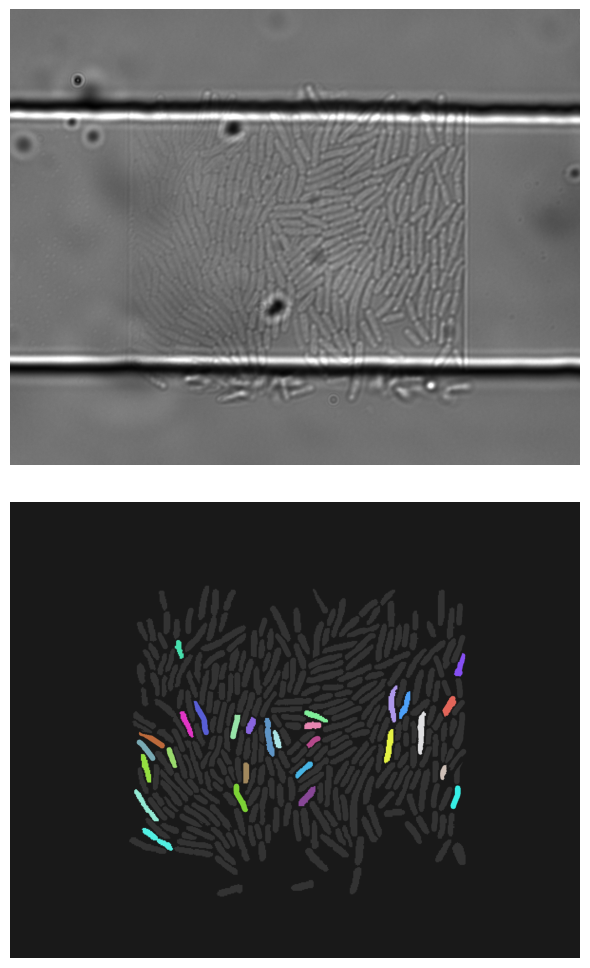

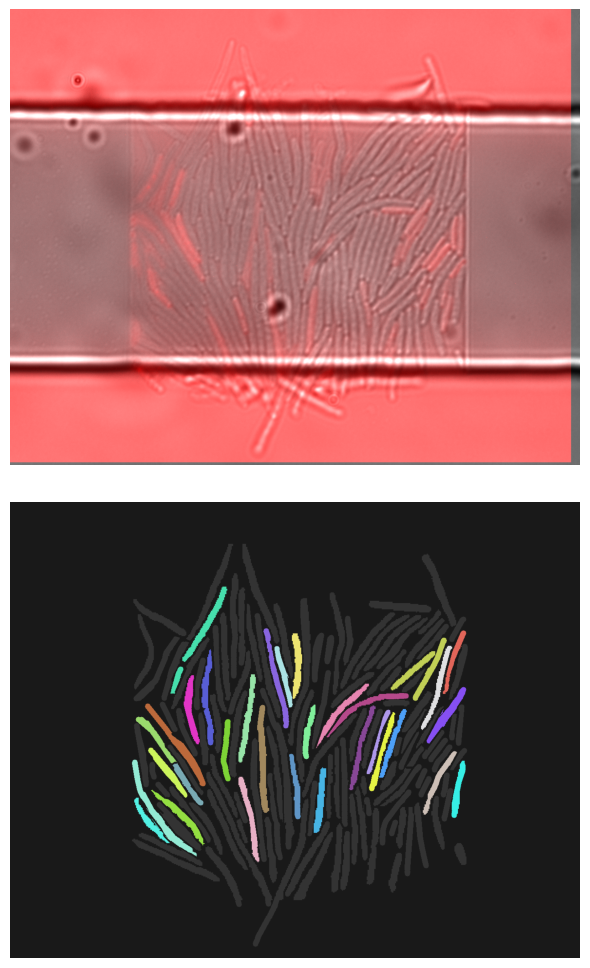

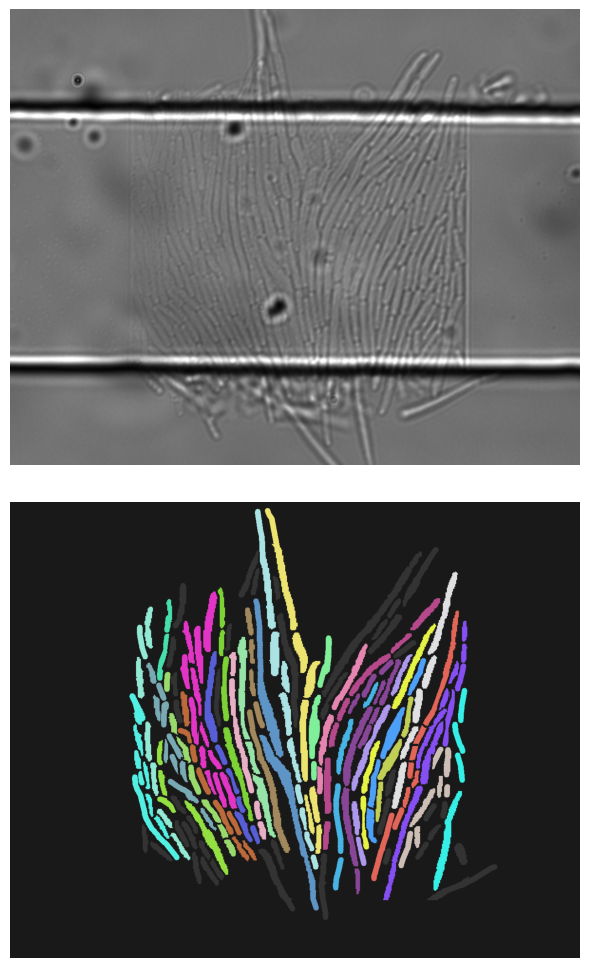

In [75]:

def compute_global_contrast_limits(images, channel="RED", lower_percentile=2, upper_percentile=98):
    """
    Computes global contrast limits across all frames for a given channel.

    Parameters:
        images (dict): Dictionary containing image channels.
        channel (str): The channel for which to compute global contrast limits.
        lower_percentile (float): Lower percentile for contrast stretching.
        upper_percentile (float): Upper percentile for contrast stretching.

    Returns:
        (float, float): Global min and max values for contrast stretching.
    """
    if channel not in images:
        raise ValueError(f"[ERROR] Channel '{channel}' not found in images.")

    all_pixel_values = np.concatenate([frame.flatten() for frame in images[channel]])
    p2, p98 = np.percentile(all_pixel_values, (lower_percentile, upper_percentile))

    return p2, p98


def plot_vertical_channels(images, frame_idx, tracked_cells_data, p2, p98, alpha_mask=0.3, alpha_cells=0.8, alpha_red=0.7):
    """
    Plots the given frame with:
      - DIC as grayscale, with RED overlaid in the red channel **only if 11 < frame_idx < 18**.
      - MASK (cells appear white, alpha=0.3) with CELLS overlaid in color (bottom).

    Parameters:
        images (dict): Dictionary containing channel names as keys and multi-frame TIFs as values.
        frame_idx (int): Index of the frame to display.
        tracked_cells_data (dict): {cell_id: {'color': (R, G, B)}}
        p2, p98 (float): Fixed contrast limits for the RED channel.
        alpha_mask (float): Transparency level for the MASK overlay (cells appear white).
        alpha_cells (float): Transparency level for the CELLS overlay.
        alpha_red (float): Scaling factor for RED overlay contrast (only applied if frame_idx in range).
    """
    # Ensure the required channels are present
    required_channels = ["DIC", "MASK", "CELLS"]
    if "RED" not in images and 11 < frame_idx < 18:
        print(f"[ERROR] Missing 'RED' channel but required for frame {frame_idx}.")
        return
    for ch in required_channels:
        if ch not in images:
            print(f"[ERROR] Missing '{ch}' channel in images.")
            return

    # Get images for the given frame
    dic_img = images["DIC"][frame_idx]
    mask_img = images["MASK"][frame_idx]
    cells_img = images["CELLS"][frame_idx]

    # Normalize DIC
    def normalize(img):
        img = img.astype(np.float32)
        return (img - img.min()) / (img.max() - img.min() + 1e-6)

    dic_img = normalize(dic_img)

    # Convert DIC to RGB (grayscale base)
    dic_rgb = np.stack([dic_img] * 3, axis=-1)

    # **Overlay RED only if 11 < frame_idx < 18**
    if 11 < frame_idx < 18:
        red_img = images["RED"][frame_idx]
        red_img = np.clip((red_img - p2) / (p98 - p2 + 1e-6), 0, 1)  # Contrast-enhanced RED
        dic_rgb[..., 0] = np.clip(dic_rgb[..., 0] + alpha_red * red_img, 0, 1)  # Add RED to R channel

    # Create an RGB white MASK image with transparency
    mask_rgb = np.zeros((*mask_img.shape, 3), dtype=np.float32)
    mask_rgb[mask_img > 0] = [1.0, 1.0, 1.0]  # White cells

    # Create an RGB image for the CELLS layer based on tracked cell colors
    cells_rgb = np.zeros((*cells_img.shape, 3), dtype=np.float32)

    unique_cells = np.unique(cells_img)
    unique_cells = unique_cells[unique_cells > 0]  # Exclude background

    for cell_id in unique_cells:
        if cell_id in tracked_cells_data:
            color = np.array(tracked_cells_data[cell_id]['color'])  # Retrieve stored color
        else:
            color = np.array([1.0, 1.0, 1.0])  # Default to white if no stored color

        mask = (cells_img == cell_id)
        for c in range(3):
            cells_rgb[..., c][mask] = color[c]  # Assign the stored color

    # Create figure with vertical layout
    fig, axes = plt.subplots(2, 1, figsize=(6, 10))

    # Plot DIC + RED (if applicable) on top
    axes[0].imshow(dic_rgb)
    title_top = "DIC" if not (11 < frame_idx < 18) else "DIC + RED"
    axes[0].axis("off")

    # Overlay MASK in white (alpha=0.3) and CELLS in color (alpha=0.8)
    axes[1].imshow(mask_rgb, alpha=alpha_mask)  # White MASK overlay
    axes[1].imshow(cells_rgb, alpha=alpha_cells)  # Colored CELLS overlay
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


global_p2, global_p98 = compute_global_contrast_limits(images, channel="RED")
for frame_idx in frames_to_compare:
    plot_vertical_channels(images, frame_idx=frame_idx, tracked_cells_data=tracked_cells_data,
                           p2=global_p2, p98=global_p98, alpha_mask=0.5, alpha_cells=0.8, alpha_red=0.7)


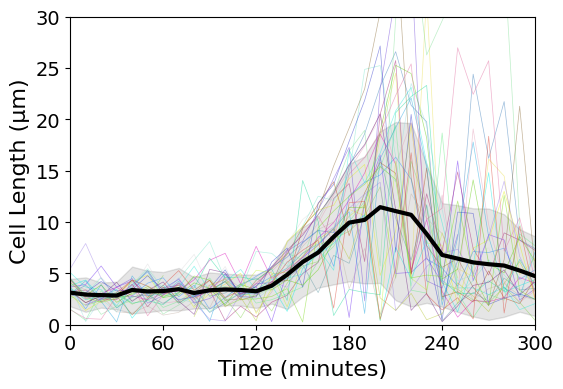

'/content/drive/MyDrive/SYNC_Projects/VIP205/figures/length_trajectories.pdf'

In [76]:
def plot_cell_length_trajectories(frames_to_analyze, frame_lengths, tracked_cells_data, ylim, figure_path):
    """
    Plots mean cell length vs. time (with SEM) and individual cell trajectories.

    Parameters:
    - frames_to_analyze (list): List of frame indices.
    - frame_lengths (list of lists): Each entry contains a list of cell lengths for a frame.
    - tracked_cells_data (dict): {cell_id: {'lengths': list of values over time, 'color': (R, G, B)}}
    - ylim (float): Upper limit for the y-axis.
    """

    mean_lengths = []
    sd_lengths = []

    for lengths in frame_lengths:
        lengths = np.array(lengths)

        if len(lengths) > 0:
            mean_lengths.append(np.mean(lengths))
            sd_lengths.append(np.std(lengths) )  # Compute Standard deviation
        else:
            mean_lengths.append(np.nan)
            sd_lengths.append(np.nan)

    # Convert frames to minutes
    time_in_minutes = np.array(frames_to_analyze) * frame2min

    # Convert lists to NumPy arrays
    mean_lengths = np.array(mean_lengths)
    sd_lengths = np.array(sd_lengths)

    # Create plot
    plt.figure(figsize=(6, 4))

    # Plot individual cell trajectories
    for cell_id, data in tracked_cells_data.items():
        cell_lengths = np.array(data['lengths'])
        color = data['color']
        plt.plot(time_in_minutes, cell_lengths, linestyle='-', color=color, alpha=0.5, lw=0.5)

    # Plot mean cell length with SEM
    plt.plot(time_in_minutes, mean_lengths, lw=3, linestyle='-', color='black', label="Mean Length")
    plt.fill_between(time_in_minutes, mean_lengths - sd_lengths, mean_lengths + sd_lengths,
                     color='black', alpha=0.1)

    plt.xlabel("Time (minutes)", fontsize=16)
    plt.ylabel("Cell Length (µm)", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    #plt.legend(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.)
    plt.ylim([0, ylim])
    plt.xlim([0, 300])
    plt.xticks([0, 60, 120, 180, 240, 300])

    # Ensure the figure directory exists
    os.makedirs(figure_path, exist_ok=True)
    save_path = os.path.join(figure_path, "length_trajectories.pdf")
    plt.savefig(save_path, format="pdf", bbox_inches="tight")

    # Close the plot to free memory
    plt.show()
    plt.close()

    return save_path


# Call the function
plot_cell_length_trajectories(frames_to_analyze, frame_lengths, tracked_cells_data, ylim=30, figure_path=figure_path)


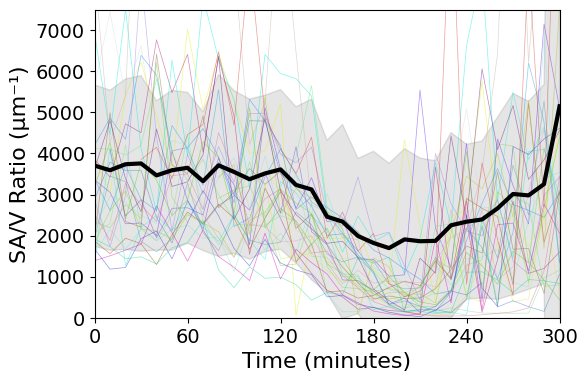

'/content/drive/MyDrive/SYNC_Projects/VIP205/figures/sa_v_ratio_trajectories.pdf'

In [77]:


def save_sa_volume_ratio_trajectories(frames_to_analyze, frame_surface_areas, frame_volumes, tracked_cells_data, ylim, figure_path):
    """
    Saves the SA/V ratio over time for multiple cells in the same plot, along with
    the mean SA/V ratio and standard error (SEM), as a PDF.

    Parameters:
    - frames_to_analyze (list): List of frame indices.
    - frame_surface_areas (list of lists): Each entry contains a list of cell surface areas for a frame.
    - frame_volumes (list of lists): Each entry contains a list of cell volumes for a frame.
    - tracked_cells_data (dict): {cell_id: {'surface_areas': [...], 'volumes': [...], 'color': (R, G, B)}}
    - ylim (float): Upper limit for the y-axis.
    - figure_path (str): Path to save the figure.
    """
    sa_v_ratios = []
    sd_sa_v_ratios = []

    for sa, vol in zip(frame_surface_areas, frame_volumes):
        sa = np.array(sa)
        vol = np.array(vol)

        # Ensure same length by truncating to the shortest list
        min_length = min(len(sa), len(vol))
        sa = sa[:min_length]
        vol = vol[:min_length]

        # Avoid division by zero errors
        valid_indices = vol > 0
        if np.any(valid_indices):
            ratio = sa[valid_indices] / vol[valid_indices]
            mean_ratio = np.mean(ratio)
            sd_ratio = np.std(ratio)  # Compute SD

            sa_v_ratios.append(mean_ratio)
            sd_sa_v_ratios.append(sd_ratio)
        else:
            sa_v_ratios.append(np.nan)
            sd_sa_v_ratios.append(np.nan)

    # Convert frames to minutes
    time_in_minutes = np.array(frames_to_analyze) * frame2min

    # Convert lists to NumPy arrays
    sa_v_ratios = np.array(sa_v_ratios)
    sd_sa_v_ratios = np.array(sd_sa_v_ratios)

    # Create figure
    plt.figure(figsize=(6, 4))

    # Plot individual cell trajectories
    for cell_id, data in tracked_cells_data.items():
        surface_areas = np.array(data['surface_areas'])
        volumes = np.array(data['volumes'])

        # Compute SA/V Ratio (Avoid division by zero)
        sa_v_cell = np.where(volumes > 0, surface_areas / volumes, np.nan)

        # Retrieve the stored color
        color = data['color']

        plt.plot(time_in_minutes, sa_v_cell, lw=0.5, linestyle='-', color=color, alpha=0.5)

    # Plot mean SA/V with SEM
    plt.plot(time_in_minutes, sa_v_ratios, linestyle='-', color='black', lw=3, label="Mean SA/V Ratio")
    plt.fill_between(time_in_minutes, sa_v_ratios - sd_sa_v_ratios, sa_v_ratios + sd_sa_v_ratios,
                     color='black', alpha=0.1)

    plt.xlabel("Time (minutes)", fontsize=16)
    plt.ylabel("SA/V Ratio (µm⁻¹)", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim([0, ylim])
    plt.xlim([0, 300])
    plt.xticks([0, 60, 120, 180, 240, 300])
    plt.grid(True, linestyle='--', alpha=0.)

    # Ensure the figure directory exists
    os.makedirs(figure_path, exist_ok=True)
    save_path = os.path.join(figure_path, "sa_v_ratio_trajectories.pdf")
    plt.savefig(save_path, format="pdf", bbox_inches="tight")

    # Close the plot to free memory
    plt.show()
    plt.close()

    return save_path


# Call function to save the figure
save_path = save_sa_volume_ratio_trajectories(frames_to_analyze, frame_surface_areas, frame_volumes, tracked_cells_data, ylim=7500, figure_path=figure_path)
save_path


In [78]:

def plot_length_vs_sa_v_contour(lengths, surface_areas, volumes, length_max, sav_max, bins=50):
    """
    Plots a 2D contour plot showing the joint distribution of cell length vs. SA/V ratio.

    Parameters:
    - lengths (list or np.ndarray): List of computed cell lengths.
    - surface_areas (list or np.ndarray): List of computed cell surface areas.
    - volumes (list or np.ndarray): List of computed cell volumes.
    - bins (int): Number of bins for histogram density estimation.
    """

    # Convert to NumPy arrays
    lengths = np.array(lengths)
    surface_areas = np.array(surface_areas)
    volumes = np.array(volumes)

    # Compute SA/V ratio
    sa_v_ratio = surface_areas / volumes  # Ensure proper division

    # Define the grid for the contour plot
    x_bins = np.linspace(min(lengths), max(lengths), bins)
    y_bins = np.linspace(min(sa_v_ratio), max(sa_v_ratio), bins)

    # Plot the contour map
    plt.figure(figsize=(6,4))
    sns.kdeplot(x=lengths, y=sa_v_ratio, cmap="Blues", fill=True, levels=20)
    plt.xlabel("Cell Length (µm)", fontsize=16)
    plt.ylabel("Surface Area / Volume (µm⁻¹)", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(alpha=0.3)
    plt.xlim([0, length_max])
    plt.ylim([0, sav_max])

    plt.show()



In [79]:

def compute_frame_statistics(frames_to_analyze, images, output_dir, experiment_id):
    """
    Computes statistics on the number of unique cells in MASKS and CELLS,
    as well as mean cell length, surface area, and volume for specified frames.
    Also calculates the total number of unique cells across all frames.

    Parameters:
    - frames_to_analyze (list): List of frame indices to analyze.
    - images (dict): Dictionary containing 'MASK' and 'CELLS' channels.
    - output_dir (str): Directory where PKL files are stored.
    - experiment_id (str): Experiment identifier used in filenames.

    Returns:
    - pd.DataFrame: Dataframe containing statistics for each frame.
    - dict: Total unique cell counts in MASK and CELLS.
    """
    stats_list = []
    all_mask_cells = set()
    all_cells_cells = set()

    for frame_index in frames_to_analyze:
        # Ensure MASK and CELLS exist
        if 'MASK' not in images or 'CELLS' not in images:
            print(f"[ERROR] Missing MASK or CELLS layer for frame {frame_index}.")
            continue

        mask_frame = images['MASK'][frame_index]
        cells_frame = images['CELLS'][frame_index]

        # Count unique cell IDs
        unique_mask_ids = np.unique(mask_frame)
        unique_mask_ids = unique_mask_ids[unique_mask_ids > 0]  # Exclude background

        unique_cells_ids = np.unique(cells_frame)
        unique_cells_ids = unique_cells_ids[unique_cells_ids > 0]  # Exclude background

        num_mask_cells = len(unique_mask_ids)
        num_cells = len(unique_cells_ids)

        # Track total unique cells across all frames
        all_mask_cells.update(unique_mask_ids)
        all_cells_cells.update(unique_cells_ids)

        # Load corresponding PKL file
        pkl_file = os.path.join(output_dir, f"{experiment_id}_frame{frame_index}.pkl")
        if not os.path.exists(pkl_file):
            print(f"[ERROR] PKL file not found for frame {frame_index}: {pkl_file}")
            continue

        with open(pkl_file, "rb") as f:
            loaded_data = pickle.load(f)

        cell_lengths = []
        cell_surface_areas = []
        cell_volumes = []

        for mask_id, data in loaded_data["cells"].items():
            if "length" in data and "surface_area" in data and "volume" in data:
                cell_lengths.append(data["length"])
                cell_surface_areas.append(data["surface_area"])
                cell_volumes.append(data["volume"])

        # Compute statistics
        mean_length = np.nanmean(cell_lengths) if cell_lengths else np.nan
        mean_surface_area = np.nanmean(cell_surface_areas) if cell_surface_areas else np.nan
        mean_volume = np.nanmean(cell_volumes) if cell_volumes else np.nan

        stats_list.append({
            "Frame": frame_index,
            "Num_MASK_Cells": num_mask_cells,
            "Num_CELLS_Cells": num_cells,
            "Mean_Length": mean_length,
            "Mean_Surface_Area": mean_surface_area,
            "Mean_Volume": mean_volume
        })

    total_unique_counts = {
        "Total Unique MASK Cells": len(all_mask_cells),
        "Total Unique CELLS Cells": len(all_cells_cells)
    }

    return pd.DataFrame(stats_list), total_unique_counts

# Run the function
df_statistics, total_counts = compute_frame_statistics(frames_to_analyze, images, output_directory, experiment_id)

# Display results
#print(df_statistics)
#print("\nTotal Unique Cell Counts:")
#print(total_counts)


In [80]:

def compare_frames(frame1, frame2, images, output_dir, experiment_id):
    """
    Compares cell-length and SA/V ratio between two frames, calculating p-values and fold increases.
    Prints the results in a human-readable format.

    Parameters:
    - frame1, frame2 (int): The frames to compare.
    - images (dict): Dictionary containing image channels.
    - output_dir (str): Directory where PKL files are stored.
    - experiment_id (str): Experiment identifier used in filenames.

    Returns:
    - None (prints results directly).
    """

    def get_frame_data(frame_index):
        """Retrieve mean length, surface area, and volume for a specific frame."""
        pkl_file = os.path.join(output_dir, f"{experiment_id}_frame{frame_index}.pkl")
        if not os.path.exists(pkl_file):
            print(f"[ERROR] PKL file not found for frame {frame_index}: {pkl_file}")
            return None, None, None

        with open(pkl_file, "rb") as f:
            loaded_data = pickle.load(f)

        cell_lengths = []
        cell_surface_areas = []
        cell_volumes = []

        for mask_id, data in loaded_data["cells"].items():
            if "length" in data and "surface_area" in data and "volume" in data:
                cell_lengths.append(data["length"])
                cell_surface_areas.append(data["surface_area"])
                cell_volumes.append(data["volume"])

        return np.array(cell_lengths), np.array(cell_surface_areas), np.array(cell_volumes)

    # Retrieve data for the two frames
    lengths_f1, sa_f1, vol_f1 = get_frame_data(frame1)
    lengths_f2, sa_f2, vol_f2 = get_frame_data(frame2)

    # Check if data is valid
    if lengths_f1 is None or lengths_f2 is None:
        print("[ERROR] One of the frames has missing data.")
        return

    # Compute SA/V Ratio (Avoid division by zero)
    sa_v_ratio_f1 = np.where(vol_f1 > 0, sa_f1 / vol_f1, np.nan)
    sa_v_ratio_f2 = np.where(vol_f2 > 0, sa_f2 / vol_f2, np.nan)

    # Compute mean values
    mean_length_f1, mean_length_f2 = np.nanmean(lengths_f1), np.nanmean(lengths_f2)
    mean_sa_f1, mean_sa_f2 = np.nanmean(sa_f1), np.nanmean(sa_f2)
    mean_vol_f1, mean_vol_f2 = np.nanmean(vol_f1), np.nanmean(vol_f2)
    mean_sa_v_ratio_f1, mean_sa_v_ratio_f2 = np.nanmean(sa_v_ratio_f1), np.nanmean(sa_v_ratio_f2)

    # Compute p-values
    p_value_length = ttest_ind(lengths_f1, lengths_f2, nan_policy='omit').pvalue
    p_value_sa_v_ratio = ttest_ind(sa_v_ratio_f1, sa_v_ratio_f2, nan_policy='omit').pvalue
    p_value_surface_area = ttest_ind(sa_f1, sa_f2, nan_policy='omit').pvalue
    p_value_volume = ttest_ind(vol_f1, vol_f2, nan_policy='omit').pvalue

    # Compute fold-increases (Avoid division by zero)
    fold_increase_sa = mean_sa_f2 / mean_sa_f1 if mean_sa_f1 > 0 else np.nan
    fold_increase_vol = mean_vol_f2 / mean_vol_f1 if mean_vol_f1 > 0 else np.nan

    # Print results in a readable format
    print("\n--- Frame Comparison Results ---")
    print(f"Comparing Frame {frame1} vs Frame {frame2}\n")

    print(f"Mean Cell Length:      {mean_length_f1:.3f} → {mean_length_f2:.3f} µm   (p = {p_value_length:.3g})")
    print(f"Mean SA/V Ratio:       {mean_sa_v_ratio_f1:.3f} → {mean_sa_v_ratio_f2:.3f} µm⁻¹   (p = {p_value_sa_v_ratio:.3g})")
    print(f"Mean Surface Area:     {mean_sa_f1:.3f} → {mean_sa_f2:.3f} µm²   (p = {p_value_surface_area:.3g})")
    print(f"Mean Volume:           {mean_vol_f1:.3f} → {mean_vol_f2:.3f} µm³   (p = {p_value_volume:.3g})")

    print(f"\nFold Increase in Surface Area: {fold_increase_sa:.2f}x")
    print(f"Fold Increase in Volume:       {fold_increase_vol:.2f}x")
    print("--------------------------------\n")

compare_frames(frames_to_compare[0], frames_to_compare[1], images, output_directory, experiment_id)
compare_frames(frames_to_compare[0], frames_to_compare[2], images, output_directory, experiment_id)



--- Frame Comparison Results ---
Comparing Frame 5 vs Frame 17

Mean Cell Length:      3.240 → 8.563 µm   (p = 5.21e-50)
Mean SA/V Ratio:       3591.436 → 1989.202 µm⁻¹   (p = 4.39e-15)
Mean Surface Area:     2864.056 → 3793.739 µm²   (p = 1.64e-13)
Mean Volume:           1.002 → 4.266 µm³   (p = 2.65e-17)

Fold Increase in Surface Area: 1.32x
Fold Increase in Volume:       4.26x
--------------------------------


--- Frame Comparison Results ---
Comparing Frame 5 vs Frame 29

Mean Cell Length:      3.240 → 5.279 µm   (p = 1.28e-13)
Mean SA/V Ratio:       3591.436 → 3253.654 µm⁻¹   (p = 0.08)
Mean Surface Area:     2864.056 → 3245.309 µm²   (p = 0.000685)
Mean Volume:           1.002 → 2.016 µm³   (p = 3.74e-06)

Fold Increase in Surface Area: 1.13x
Fold Increase in Volume:       2.01x
--------------------------------



In [81]:

def compare_frames(frame1, frame2, images, output_dir, experiment_id):
    """
    Compares cell-length and SA/V ratio between two frames, calculating p-values and fold increases.
    Prints the results in a human-readable format.

    Parameters:
    - frame1, frame2 (int): The frames to compare.
    - images (dict): Dictionary containing image channels.
    - output_dir (str): Directory where PKL files are stored.
    - experiment_id (str): Experiment identifier used in filenames.

    Returns:
    - None (prints results directly).
    """

    def get_frame_data(frame_index):
        """Retrieve mean length, surface area, and volume for a specific frame."""
        pkl_file = os.path.join(output_dir, f"{experiment_id}_frame{frame_index}.pkl")
        if not os.path.exists(pkl_file):
            print(f"[ERROR] PKL file not found for frame {frame_index}: {pkl_file}")
            return None, None, None

        with open(pkl_file, "rb") as f:
            loaded_data = pickle.load(f)

        cell_lengths = []
        cell_surface_areas = []
        cell_volumes = []

        for mask_id, data in loaded_data["cells"].items():
            if "length" in data and "surface_area" in data and "volume" in data:
                cell_lengths.append(data["length"])
                cell_surface_areas.append(data["surface_area"])
                cell_volumes.append(data["volume"])

        return np.array(cell_lengths), np.array(cell_surface_areas), np.array(cell_volumes)

    # Retrieve data for the two frames
    lengths_f1, sa_f1, vol_f1 = get_frame_data(frame1)
    lengths_f2, sa_f2, vol_f2 = get_frame_data(frame2)

    # Check if data is valid
    if lengths_f1 is None or lengths_f2 is None:
        print("[ERROR] One of the frames has missing data.")
        return

    # Compute SA/V Ratio (Avoid division by zero)
    sa_v_ratio_f1 = np.where(vol_f1 > 0, sa_f1 / vol_f1, np.nan)
    sa_v_ratio_f2 = np.where(vol_f2 > 0, sa_f2 / vol_f2, np.nan)

    # Compute mean values
    mean_length_f1, mean_length_f2 = np.nanmean(lengths_f1), np.nanmean(lengths_f2)
    mean_sa_f1, mean_sa_f2 = np.nanmean(sa_f1), np.nanmean(sa_f2)
    mean_vol_f1, mean_vol_f2 = np.nanmean(vol_f1), np.nanmean(vol_f2)
    mean_sa_v_ratio_f1, mean_sa_v_ratio_f2 = np.nanmean(sa_v_ratio_f1), np.nanmean(sa_v_ratio_f2)

    # Compute p-values
    p_value_length = ttest_ind(lengths_f1, lengths_f2, nan_policy='omit').pvalue
    p_value_sa_v_ratio = ttest_ind(sa_v_ratio_f1, sa_v_ratio_f2, nan_policy='omit').pvalue
    p_value_surface_area = ttest_ind(sa_f1, sa_f2, nan_policy='omit').pvalue
    p_value_volume = ttest_ind(vol_f1, vol_f2, nan_policy='omit').pvalue

    # Compute fold-increases (Avoid division by zero)
    fold_increase_sa = mean_sa_f2 / mean_sa_f1 if mean_sa_f1 > 0 else np.nan
    fold_increase_vol = mean_vol_f2 / mean_vol_f1 if mean_vol_f1 > 0 else np.nan

    # Print results in a readable format
    print("\n--- Frame Comparison Results ---")
    print(f"Comparing Frame {frame1} vs Frame {frame2}\n")

    print(f"Mean Cell Length:      {mean_length_f1:.3f} → {mean_length_f2:.3f} µm   (p = {p_value_length:.3g})")
    print(f"Mean SA/V Ratio:       {mean_sa_v_ratio_f1:.3f} → {mean_sa_v_ratio_f2:.3f} µm⁻¹   (p = {p_value_sa_v_ratio:.3g})")
    print(f"Mean Surface Area:     {mean_sa_f1:.3f} → {mean_sa_f2:.3f} µm²   (p = {p_value_surface_area:.3g})")
    print(f"Mean Volume:           {mean_vol_f1:.3f} → {mean_vol_f2:.3f} µm³   (p = {p_value_volume:.3g})")

    print(f"\nFold Increase in Surface Area: {fold_increase_sa:.2f}x")
    print(f"Fold Increase in Volume:       {fold_increase_vol:.2f}x")
    print("--------------------------------\n")

compare_frames(frames_to_compare[0], frames_to_compare[1], images, output_directory, experiment_id)
compare_frames(frames_to_compare[0], frames_to_compare[2], images, output_directory, experiment_id)



--- Frame Comparison Results ---
Comparing Frame 5 vs Frame 17

Mean Cell Length:      3.240 → 8.563 µm   (p = 5.21e-50)
Mean SA/V Ratio:       3591.436 → 1989.202 µm⁻¹   (p = 4.39e-15)
Mean Surface Area:     2864.056 → 3793.739 µm²   (p = 1.64e-13)
Mean Volume:           1.002 → 4.266 µm³   (p = 2.65e-17)

Fold Increase in Surface Area: 1.32x
Fold Increase in Volume:       4.26x
--------------------------------


--- Frame Comparison Results ---
Comparing Frame 5 vs Frame 29

Mean Cell Length:      3.240 → 5.279 µm   (p = 1.28e-13)
Mean SA/V Ratio:       3591.436 → 3253.654 µm⁻¹   (p = 0.08)
Mean Surface Area:     2864.056 → 3245.309 µm²   (p = 0.000685)
Mean Volume:           1.002 → 2.016 µm³   (p = 3.74e-06)

Fold Increase in Surface Area: 1.13x
Fold Increase in Volume:       2.01x
--------------------------------

